<center><h1>AReM Data Set : Time Series Classification</h1></center>


<h3>Q1. Time Series Classification Part 1: Feature Creation/Extraction</h3>

<p>An interesting task in machine learning is classification of time series. In this problem, we will classify the activities of humans based on time series obtained by a Wireless Sensor Network.</p>

<h1>Common code for HW3 and HW4 - Includes Data Cleaning, Reading the Data, Splitting it into train and test data and Feature extraction for getting the Time series values.</h1>

<h1>Start of HW4 has been demarcated below with a proper heading and question number as per the homework description</h1>

<h3>Q1. (a)  Download the AReM data from: <a href="https://archive.ics.uci.edu/dataset/366/activity+recognition+system+based+on+multisensor+data+fusion+arem">https://archive.ics.uci.edu/dataset/366/activity+recognition+system+based+on+multisensor+data+fusion+arem .</a> 
 <br> <br>
    The dataset contains 7 folders that represent seven types of activities. In each folder, there are multiple files each of which represents an instant of a human performing an activity. Each file containis 6 time series collected from activities of the same person, which are called avg_rss12, var_rss12, avg_rss13, var_rss13,vg_rss23, and ar_rss23. There are 88 instances in the dataset, each of which contains 6 time series and each time series has 480 consecutive values.</h3>

In [155]:
#upgrading the scikit-learn library
!pip install --upgrade scikit-learn

In [156]:
#importing the libraries required for HW3 and HW4
import warnings 
warnings. filterwarnings('ignore')

import pandas as pd
import numpy as np
import os
from scipy.stats import bootstrap
import statistics
import seaborn as sns
import csv

#Importing scikit learn libraries
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from collections import Counter
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score, auc
from sklearn.preprocessing import label_binarize

<p><b>Downloading the AReM Dataset and reading the data</b></p>

In [157]:
#reading the arem dataset
arem_df = pd.read_csv("../Data/AReM/bending1/dataset1.csv", skiprows=4)
columnNames_arem = ['time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
arem_df.columns = columnNames_arem
display(arem_df)

time  avg_rss12  var_rss12  avg_rss13  var_rss13  avg_rss23  var_rss23
0         0      39.25       0.43      22.75       0.43      33.75        1.3
1       250      39.25       0.43      23.00       0.00      33.00        0.0
2       500      39.25       0.43      23.25       0.43      33.00        0.0
3       750      39.50       0.50      23.00       0.71      33.00        0.0
4      1000      39.50       0.50      24.00       0.00      33.00        0.0
..      ...        ...        ...        ...        ...        ...        ...
475  118750      43.33       0.47      25.00       0.00      30.00        0.0
476  119000      43.50       0.50      25.50       0.50      30.00        0.0
477  119250      43.50       0.50      24.75       0.43      30.00        0.0
478  119500      43.50       0.50      24.33       0.47      30.00        0.0
479  119750      43.50       0.50      24.25       0.43      30.00        0.0

[480 rows x 7 columns]

<p><b>Reading and accessing the AReM Dataset</b></p>
<p><b>I have made some modifications in the read data code, to make it easier to access the data and in order to perform the Binary and Multiclass Classification</b></p>

<h3>Q1. (b). Keep datasets 1 and 2 in folders bending1 and bending 2, as well as datasets 1, 2, and 3 in other folders as test data and other datasets as train data.
</h3>

In [158]:
Arem_columns = ['time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']

train_df = pd.DataFrame(columns=Arem_columns)
test_df = pd.DataFrame(columns=Arem_columns)

train_activity_dict = dict();
test_activity_dict = dict();

base_dir = '../data/AReM/';
    
for folder in os.listdir(base_dir):
    if os.path.isdir(base_dir+folder):
        if(folder=='bending1' or folder=='bending2'):
            for file in os.listdir(base_dir+folder):
                if(file=='dataset1.csv' or file=='dataset2.csv'):

                    curr_df = pd.read_csv(base_dir+folder+"/"+file, skiprows=5, names = Arem_columns, index_col=False,on_bad_lines='warn')

                    test_df = pd.concat([test_df, curr_df])
                    test_activity_dict.setdefault(folder, []).append(curr_df)
                else: 
                    if(file=='dataset4.csv' and folder =='bending2'):

                        curr_df = pd.read_csv(base_dir+folder+"/"+file, skiprows=5, names = Arem_columns, delimiter=' ', index_col=False,on_bad_lines='warn')

                        train_df = pd.concat([train_df, curr_df]) 
                        train_activity_dict.setdefault(folder, []).append(curr_df)
                    else:

                        curr_df = pd.read_csv(base_dir+folder+"/"+file, skiprows=5, names = Arem_columns, index_col=False,on_bad_lines='warn')

                        train_df = pd.concat([train_df, curr_df])   
                        train_activity_dict.setdefault(folder, []).append(curr_df)
        else:
            for file in os.listdir(base_dir+folder):
                if(file=='dataset1.csv' or file=='dataset2.csv' or file=='dataset3.csv'):

                    curr_df = pd.read_csv(base_dir+folder+"/"+file, skiprows=5, names = Arem_columns, index_col=False,on_bad_lines='warn')

                    test_df = pd.concat([test_df, curr_df])
                    test_activity_dict.setdefault(folder, []).append(curr_df)
                else:

                    curr_df = pd.read_csv(base_dir+folder+"/"+file, skiprows=5, names = Arem_columns, index_col=False,on_bad_lines='warn')
                    train_df = pd.concat([train_df, curr_df])

                    train_activity_dict.setdefault(folder, []).append(curr_df)


train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)


Skipping line 485: expected 7 fields, saw 8

Skipping line 485: expected 7 fields, saw 8



In [159]:
print('Training Data\n')
print('----------------------------------------------')
display(train_df)
print('\nTesting Data\n')
print('----------------------------------------------')
display(test_df)

Training Data

----------------------------------------------


time  avg_rss12  var_rss12  avg_rss13  var_rss13  avg_rss23  \
0           0      42.00       0.71      21.25       0.43      30.00   
1         250      41.50       0.50      20.25       1.48      31.25   
2         500      41.50       0.50      14.25       1.92      33.00   
3         750      40.75       0.83      15.75       0.43      33.00   
4        1000      40.00       0.71      20.00       2.74      32.75   
...       ...        ...        ...        ...        ...        ...   
33112  118750      31.50       1.66      12.50       3.20      14.25   
33113  119000      27.33       1.25      11.33       0.94      20.00   
33114  119250      37.80       7.68      14.20       2.48      17.25   
33115  119500      33.75       1.30      15.75       5.21      16.50   
33116  119750      32.67       3.09      18.67       0.47      14.00   

       var_rss23  
0           0.00  
1           1.09  
2           0.00  
3           0.00  
4           0.43  
...          ...  
33112       4.44  
33113       4.00  
33114       0.83  
33115       2.69  
33116       3.16  

[33117 rows x 7 columns]


Testing Data

----------------------------------------------


time  avg_rss12  var_rss12  avg_rss13  var_rss13  avg_rss23  var_rss23
0          0      39.25       0.43      22.75       0.43      33.75       1.30
1        250      39.25       0.43      23.00       0.00      33.00       0.00
2        500      39.25       0.43      23.25       0.43      33.00       0.00
3        750      39.50       0.50      23.00       0.71      33.00       0.00
4       1000      39.50       0.50      24.00       0.00      33.00       0.00
...      ...        ...        ...        ...        ...        ...        ...
9115  118750      36.00       2.45      17.00       5.10      20.50       0.87
9116  119000      34.33       1.89      15.00       2.45      17.00       2.12
9117  119250      33.00       7.35      14.60       3.14      13.00       5.70
9118  119500      31.67       1.25      11.00       6.16      19.25       2.17
9119  119750      30.75      10.21      11.75       1.09      18.50       3.20

[9120 rows x 7 columns]

<h3>Q1. (c)Feature Extraction <br>
Classification of time series usually needs extracting features from them. In this problem, we focus on time-domain features.
</h3>

<h3>Q1. (c)(i). Research what types of time-domain features are usually used in time series classification and list them (examples are minimum, maximum, mean, etc).</h3>

<h4>Some common types of time-domain features that are usually used in time series classification include:</h4>

<ol>
    <li><b>Mean:</b> Average value of the signal. It provides the central tendency of data.</li>
  <li><b>Median:</b> It represents the central value of the dataset and is less affected by outliers than the mean.</li>
  <li><b>Standard deviation:</b>  Measures the dispersion or variability of the data points from the mean. </li>
  <li><b>Variance:</b> The square of the standard deviation. It measures the spread of the data points around the mean.</li>
 
  <li><b>Interquartile range:</b> Measure of the statistical dispersion, being equal to the difference between the 3rd quartile and the 1st quarile of the signal over the time window</li>
  <li><b>Zero crossing rate:</b> The rate at which the signal changes from positive to negative or back. </li>
  <li> <b>Mean crossing rate:</b> Rate of signal changes from below average to above average or vice versa</li>
  <li><b>Root Mean Square (RMS):</b> The square root of the mean of the squares of all data points.</li>
  <li> <b>Min:</b> The minimum value of the signal.</li>
  <li> <b>Max:</b> The maximum value of the signal.</li>
    <li><b>Pairwise Correlation:</b> Correlation between two axes of each sensor and different sensors</li>
 
  <li><b>Averaged Derivatives:</b> The mean value of the first order derivatives of the signal over the time window</li>
  <li><b>Skewness:</b> A measure of the asymmetry of the probability distribution of the data points.</li>
  <li><b>Kurtosis:</b> Measures the "tailedness" of the probability distribution of a real-valued random variable. </li>
 
  <li><b>Entropy:</b> A measure of the unpredictability or randomness of the data distribution. Higher entropy indicates more randomness.</li>

<li><b>Autocorrelation:</b> Measures the correlation of a signal with a delayed copy of itself as a function of delay. It can identify repeating patterns or periodic signals.</li>

<li><b>Peak-to-Peak Distance:</b> The difference between the maximum and minimum values. This metric gives a sense of the overall variability in the dataset.</li>

<li><b>Signal-to-Noise Ratio (SNR):</b> The ratio of the mean power of the signal to the mean power of the background noise. It quantifies how much the signal stands out from the noise.</li>
    
</ol>  

<h3>Q1. (c) ii. Extract the time-domain features minimum, maximum, mean, median, standard deviation, first quartile, and third quartile for all of the 6 time series in each instance. You are free to normalize/standardize features or use them directly.</h3>

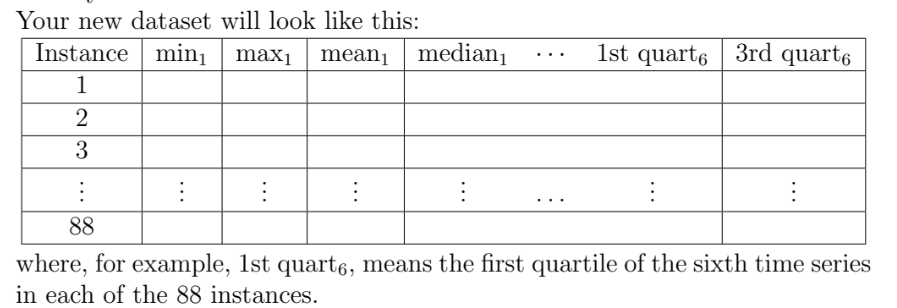

In [160]:

def read_csv_file(folder, file, column_names):
    file_path = os.path.join(base_dir, folder, file)
    delimiter = ' ' if (folder == 'bending2' and file == 'dataset4.csv') else ','
    return pd.read_csv(file_path, skiprows=5, names=column_names, delimiter=delimiter, index_col=False, on_bad_lines='warn')

def calculate_statistics(df):
    stats = {}
    for col in df.columns[1:]:  # Excluding the first column (assumed to be 'time')
        stats.update({
            f'min{df.columns.get_loc(col)}': df[col].min(),
            f'max{df.columns.get_loc(col)}': df[col].max(),
            f'mean{df.columns.get_loc(col)}': df[col].mean(),
            f'median{df.columns.get_loc(col)}': df[col].median(),
            f'std{df.columns.get_loc(col)}': df[col].std(),
            f'firstquartile{df.columns.get_loc(col)}': df[col].quantile(0.25),
            f'thirdquartile{df.columns.get_loc(col)}': df[col].quantile(0.75),
        })
    return stats

def process_files(base_dir, column_names):
    instance_dict = {}
    instance = 1

    for folder in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                curr_df = read_csv_file(folder, file, column_names)
                stats_dict = calculate_statistics(curr_df)
                stats_dict['activity'] = folder
                stats_dict['dataset'] = file
                instance_dict[instance] = stats_dict
                instance += 1

    return pd.DataFrame.from_dict(instance_dict, orient='index')

stats_df = process_files(base_dir, Arem_columns)
stats_df


Skipping line 485: expected 7 fields, saw 8

Skipping line 485: expected 7 fields, saw 8



min1   max1      mean1  median1      std1  firstquartile1  \
1   37.25  45.00  40.624792   40.500  1.476967           39.25   
2   38.00  45.67  42.812812   42.500  1.435550           42.00   
3   35.00  47.40  43.954500   44.330  1.558835           43.00   
4   33.00  47.75  42.179812   43.500  3.670666           39.15   
5   33.00  45.75  41.678063   41.750  2.243490           41.33   
..    ...    ...        ...      ...       ...             ...   
84  20.75  46.25  34.763333   35.290  4.742208           31.67   
85  21.50  51.00  34.935812   35.500  4.645944           32.00   
86  18.33  47.67  34.333042   34.750  4.948770           31.25   
87  18.33  45.75  34.599875   35.125  4.731790           31.50   
88  15.50  43.67  34.225875   34.750  4.441798           31.25   

    thirdquartile1  min2   max2     mean2  ...  thirdquartile5  min6   max6  \
1          42.0000   0.0   1.30  0.358604  ...           36.00   0.0   1.92   
2          43.6700   0.0   1.22  0.372437  ...           34.50   0.0   3.11   
3          45.0000   0.0   1.70  0.426250  ...           36.50   0.0   1.79   
4          45.0000   0.0   3.00  0.696042  ...           36.33   0.0   2.18   
5          42.7500   0.0   2.83  0.535979  ...           31.25   0.0   1.79   
..             ...   ...    ...       ...  ...             ...   ...    ...   
84         38.2500   0.0  12.68  4.223792  ...           18.33   0.0   9.39   
85         38.0625   0.0  12.21  4.115750  ...           18.25   0.0  10.21   
86         38.0000   0.0  12.48  4.396958  ...           18.00   0.0   8.01   
87         38.0000   0.0  15.37  4.398833  ...           18.25   0.0   8.86   
88         37.2500   0.0  17.24  4.354500  ...           18.25   0.0   9.42   

       mean6  median6      std6  firstquartile6  thirdquartile6  activity  \
1   0.570583    0.430  0.582915            0.00          1.3000  bending1   
2   0.571083    0.430  0.601010            0.00          1.3000  bending1   
3   0.493292    0.430  0.513506            0.00          0.9400  bending1   
4   0.613521    0.500  0.524317            0.00          1.0000  bending1   
5   0.383292    0.430  0.389164            0.00          0.5000  bending1   
..       ...      ...       ...             ...             ...       ...   
84  3.288271    3.270  1.647528            2.05          4.3050   walking   
85  3.280021    3.015  1.700918            2.12          4.5000   walking   
86  3.261583    2.980  1.617290            2.05          4.3200   walking   
87  3.289542    3.015  1.680170            2.12          4.2600   walking   
88  3.479542    3.270  1.761146            2.24          4.5375   walking   

         dataset  
1   dataset1.csv  
2   dataset2.csv  
3   dataset3.csv  
4   dataset4.csv  
5   dataset5.csv  
..           ...  
84  dataset5.csv  
85  dataset6.csv  
86  dataset7.csv  
87  dataset8.csv  
88  dataset9.csv  

[88 rows x 44 columns]

In [161]:


def refine_stats_df(df):
    df_refined = df.iloc[:, :-2].copy()
    df_refined.insert(0, 'instance', df.index)
    return df_refined


stats_df_refined = refine_stats_df(stats_df)
stats_df_refined_dropped = stats_df_refined.drop(columns=['instance'])
display(stats_df_refined_dropped)


min1   max1      mean1  median1      std1  firstquartile1  \
1   37.25  45.00  40.624792   40.500  1.476967           39.25   
2   38.00  45.67  42.812812   42.500  1.435550           42.00   
3   35.00  47.40  43.954500   44.330  1.558835           43.00   
4   33.00  47.75  42.179812   43.500  3.670666           39.15   
5   33.00  45.75  41.678063   41.750  2.243490           41.33   
..    ...    ...        ...      ...       ...             ...   
84  20.75  46.25  34.763333   35.290  4.742208           31.67   
85  21.50  51.00  34.935812   35.500  4.645944           32.00   
86  18.33  47.67  34.333042   34.750  4.948770           31.25   
87  18.33  45.75  34.599875   35.125  4.731790           31.50   
88  15.50  43.67  34.225875   34.750  4.441798           31.25   

    thirdquartile1  min2   max2     mean2  ...      std5  firstquartile5  \
1          42.0000   0.0   1.30  0.358604  ...  2.188449         33.0000   
2          43.6700   0.0   1.22  0.372437  ...  1.995255         32.0000   
3          45.0000   0.0   1.70  0.426250  ...  1.999604         35.3625   
4          45.0000   0.0   3.00  0.696042  ...  3.849448         30.4575   
5          42.7500   0.0   2.83  0.535979  ...  2.411026         28.4575   
..             ...   ...    ...       ...  ...       ...             ...   
84         38.2500   0.0  12.68  4.223792  ...  3.174681         14.2500   
85         38.0625   0.0  12.21  4.115750  ...  3.192058         14.2375   
86         38.0000   0.0  12.48  4.396958  ...  3.000493         13.7500   
87         38.0000   0.0  15.37  4.398833  ...  2.905688         14.0000   
88         37.2500   0.0  17.24  4.354500  ...  2.992920         14.3300   

    thirdquartile5  min6   max6     mean6  median6      std6  firstquartile6  \
1            36.00   0.0   1.92  0.570583    0.430  0.582915            0.00   
2            34.50   0.0   3.11  0.571083    0.430  0.601010            0.00   
3            36.50   0.0   1.79  0.493292    0.430  0.513506            0.00   
4            36.33   0.0   2.18  0.613521    0.500  0.524317            0.00   
5            31.25   0.0   1.79  0.383292    0.430  0.389164            0.00   
..             ...   ...    ...       ...      ...       ...             ...   
84           18.33   0.0   9.39  3.288271    3.270  1.647528            2.05   
85           18.25   0.0  10.21  3.280021    3.015  1.700918            2.12   
86           18.00   0.0   8.01  3.261583    2.980  1.617290            2.05   
87           18.25   0.0   8.86  3.289542    3.015  1.680170            2.12   
88           18.25   0.0   9.42  3.479542    3.270  1.761146            2.24   

    thirdquartile6  
1           1.3000  
2           1.3000  
3           0.9400  
4           1.0000  
5           0.5000  
..             ...  
84          4.3050  
85          4.5000  
86          4.3200  
87          4.2600  
88          4.5375  

[88 rows x 42 columns]

<p><b>Extracting the Time Domain Features:</b></p>

<h3>Q1. (c) iii. Estimate the standard deviation of each of the time-domain features you extracted from the data. Then, use Python’s bootstrapped or any other method to build a 90% bootsrap confidence interval for the standard deviation of each feature</h3>

<h3>Using python’s bootstrapped method to build a 90% bootsrap confidence interval for the standard deviation of each time domain feature</h3>

In [162]:
std_dev_dict = dict()
conf_interval_dict = dict()

for col in stats_df_refined.columns[1:]:
    std_dev = statistics.stdev(stats_df_refined[col])
    std_dev_dict[col] = std_dev
    conf_interval = bootstrap((stats_df_refined[col],), np.std, confidence_level=0.90,
                              random_state=1, method='percentile').confidence_interval
    conf_interval_dict[col] = conf_interval

std_dev_df = pd.DataFrame.from_dict(std_dev_dict, orient='index', columns=['standard_deviation'])
conf_interval_df = pd.DataFrame.from_dict(conf_interval_dict, orient='index', columns=['90% confidence_interval_lower', '90% confidence_interval_upper'])



In [163]:
print("Standard Deviation Table:")
display(std_dev_df)

Standard Deviation Table:


standard_deviation
min1                      9.569975
max1                      4.394362
mean1                     5.335700
median1                   5.440054
std1                      1.772185
firstquartile1            6.153874
thirdquartile1            5.138925
min2                      0.000000
max2                      5.062729
mean2                     1.574198
median2                   1.412293
std2                      0.884137
firstquartile2            0.946386
thirdquartile2            2.125399
min3                      2.956462
max3                      4.875137
mean3                     4.008228
median3                   4.036396
std3                      0.946670
firstquartile3            4.220658
thirdquartile3            4.171628
min4                      0.000000
max4                      2.183625
mean4                     1.166178
median4                   1.145985
std4                      0.458283
firstquartile4            0.843405
thirdquartile4            1.552504
min5                      6.124001
max5                      5.741238
mean5                     5.675543
median5                   5.813782
std5                      1.024918
firstquartile5            6.096465
thirdquartile5            5.531720
min6                      0.045838
max6                      2.518921
mean6                     1.154889
median6                   1.086474
std6                      0.517651
firstquartile6            0.758687
thirdquartile6            1.523739

In [164]:
print("\nConfidence Interval Table:")
display(conf_interval_df)



Confidence Interval Table:


90% confidence_interval_lower  90% confidence_interval_upper
min1                                 8.208212                      10.718897
max1                                 3.302124                       5.277910
mean1                                4.683090                       5.864942
median1                              4.774987                       5.983471
std1                                 1.561618                       1.930543
firstquartile1                       5.549271                       6.619699
thirdquartile1                       4.299096                       5.819304
min2                                 0.000000                       0.000000
max2                                 4.598099                       5.372570
mean2                                1.388117                       1.698047
median2                              1.231864                       1.536225
std2                                 0.798036                       0.937238
firstquartile2                       0.826863                       1.030031
thirdquartile2                       1.884007                       2.283621
min3                                 2.743199                       3.089735
max3                                 4.148242                       5.435277
mean3                                3.397149                       4.471425
median3                              3.413553                       4.519072
std3                                 0.755890                       1.118393
firstquartile3                       3.609384                       4.677967
thirdquartile3                       3.519166                       4.668927
min4                                 0.000000                       0.000000
max4                                 1.962949                       2.344990
mean4                                1.068754                       1.216439
median4                              1.048973                       1.196141
std4                                 0.418821                       0.483576
firstquartile4                       0.770863                       0.886741
thirdquartile4                       1.423182                       1.618276
min5                                 4.399817                       7.457930
max5                                 4.724509                       6.527828
mean5                                4.412399                       6.709770
median5                              4.507174                       6.875662
std5                                 0.808694                       1.215822
firstquartile5                       4.783229                       7.174153
thirdquartile5                       4.341901                       6.515529
min6                                 0.000000                       0.078029
max6                                 2.239321                       2.741976
mean6                                1.056055                       1.208699
median6                              0.989864                       1.142219
std6                                 0.476160                       0.542716
firstquartile6                       0.686008                       0.803483
thirdquartile6                       1.394317                       1.592006

In [165]:

combined_df = std_dev_df.join(conf_interval_df)
print("Combined Standard Deviation and Confidence Interval Table:")
display(combined_df)


Combined Standard Deviation and Confidence Interval Table:


standard_deviation  90% confidence_interval_lower  \
min1                      9.569975                       8.208212   
max1                      4.394362                       3.302124   
mean1                     5.335700                       4.683090   
median1                   5.440054                       4.774987   
std1                      1.772185                       1.561618   
firstquartile1            6.153874                       5.549271   
thirdquartile1            5.138925                       4.299096   
min2                      0.000000                       0.000000   
max2                      5.062729                       4.598099   
mean2                     1.574198                       1.388117   
median2                   1.412293                       1.231864   
std2                      0.884137                       0.798036   
firstquartile2            0.946386                       0.826863   
thirdquartile2            2.125399                       1.884007   
min3                      2.956462                       2.743199   
max3                      4.875137                       4.148242   
mean3                     4.008228                       3.397149   
median3                   4.036396                       3.413553   
std3                      0.946670                       0.755890   
firstquartile3            4.220658                       3.609384   
thirdquartile3            4.171628                       3.519166   
min4                      0.000000                       0.000000   
max4                      2.183625                       1.962949   
mean4                     1.166178                       1.068754   
median4                   1.145985                       1.048973   
std4                      0.458283                       0.418821   
firstquartile4            0.843405                       0.770863   
thirdquartile4            1.552504                       1.423182   
min5                      6.124001                       4.399817   
max5                      5.741238                       4.724509   
mean5                     5.675543                       4.412399   
median5                   5.813782                       4.507174   
std5                      1.024918                       0.808694   
firstquartile5            6.096465                       4.783229   
thirdquartile5            5.531720                       4.341901   
min6                      0.045838                       0.000000   
max6                      2.518921                       2.239321   
mean6                     1.154889                       1.056055   
median6                   1.086474                       0.989864   
std6                      0.517651                       0.476160   
firstquartile6            0.758687                       0.686008   
thirdquartile6            1.523739                       1.394317   

                90% confidence_interval_upper  
min1                                10.718897  
max1                                 5.277910  
mean1                                5.864942  
median1                              5.983471  
std1                                 1.930543  
firstquartile1                       6.619699  
thirdquartile1                       5.819304  
min2                                 0.000000  
max2                                 5.372570  
mean2                                1.698047  
median2                              1.536225  
std2                                 0.937238  
firstquartile2                       1.030031  
thirdquartile2                       2.283621  
min3                                 3.089735  
max3                                 5.435277  
mean3                                4.471425  
median3                              4.519072  
std3                                 1.118393  
firstquartile3                       4.677967  
thirdquartile3                       4.6

<h4>Standar Deviation of each Time Domain Feature</h4>

<h3>Q1. (c) iv. Use your judgement to select the three most important time-domain features (one option may be min, mean, and max)</h3>

<h4>The three most important Time Domain Features as per my judegement and considerations are:</h4>

<ol>
    <li><b>Mean:</b> The mean is often chosen as the best measure of central tendency for continuous data because it incorporates every value in the dataset, providing a comprehensive representation. It possesses desirable mathematical properties that facilitate further statistical analysis and modeling, particularly in linear models where it minimizes the sum of squared deviations.</li>
    <li><b>First Quartile:</b> The first quartile (Q1) is valuable for understanding the lower range of a dataset, aiding in outlier detection and assessing data dispersion. It provides insights into the distribution's lower segment, facilitating comparative analysis and data segmentation. While its applicability may vary, Q1 is particularly useful in analyses focused on the distribution's lower extremes or when segmenting data for a detailed examination.</li>
    <li><b>Standard Deviation:</b> Standard deviation is considered an ideal measure of dispersion because it quantifies the amount of variation or spread in a set of data values, providing insights into the data's volatility. It is directly related to the mean, offering a context for understanding variability relative to the central tendency. Additionally, in normal distributions, it helps define the proportion of data within specific intervals, making it invaluable for statistical analysis and pattern recognition.</li>

<h3>Considering the part 2 of the Time Series Classification, I am changing my second most important Time domain Featute from First Quartile to <b>Median</b> to get considerable better and accurate results</h3>
<h3>Hence, the important Time domanin features are Mean, Median and Stabdard Deviation.</h3>

<h3>Q2. ISLR 3.7.4</h3>

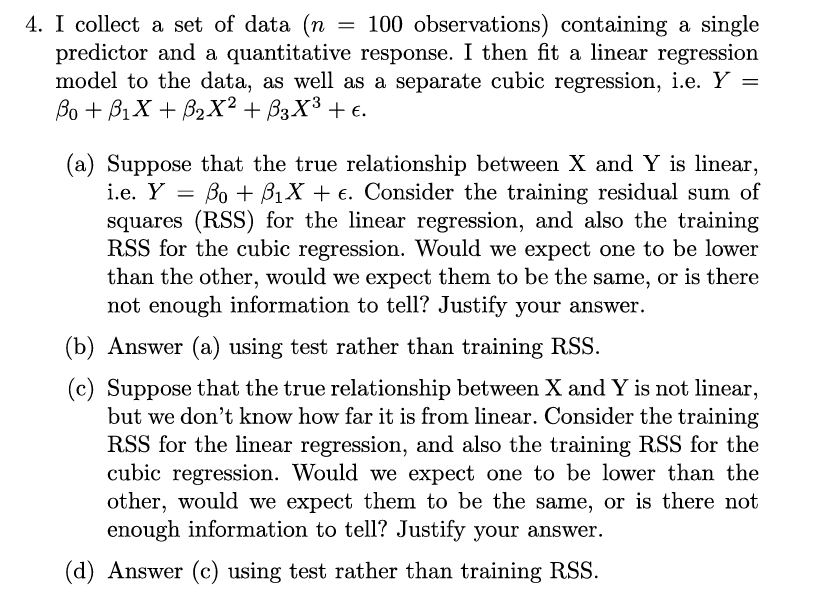


<h3>Q2. (a). Linear Train RSS </h3>
<p>  If the true relationship between X and Y is linear, the linear regression model is expected to fit the data well, leading to a low training RSS. The training Residual Sum of Squares is typically lower for the cubic regression than for the linear regression. This occurs because the cubic model, due to its complexity, can fit more closely to the data points, potentially to the extent of fitting the random noise, known as overfitting, which leads to a reduced/lower RSS.</p>

<h3>Q2. (b). Linear Test RSS </h3>
<p> For the linear model, the test Residual Sum of Squares is expected to be lower if the test data adheres to a linear pattern. Overfitting could occur with the cubic model on the training data, leading to larger error residuals when it is applied to the test data.</p>

<h3>Q2. (c). Not Linear Train RSS </h3>
<p> Due to its greater number of parameters, the cubic regression model is inherently more adaptable, allowing it to closely trace the training data points. This adaptability leads to a reduction in the training Residual Sum of Squares, a trend that holds true regardless of the underlying linear or non-linear relationship between X and Y..</p>

<h3>Q2. (d). Not Linear Test RSS </h3>
<p> On test data, if the true relationship is not linear, the cubic regression may perform better than linear regression and have a lower test RSS, provided it captures the underlying relationship without overfitting. But without knowing how close the true relationship is to either model, we cannot be certain which will perform better on new data.</p>

<h1>===================================================</h1>
<h1>HW4 Starts here:</h1>
<h1>===================================================</h1>

<h3>2. Time Series Classification Part 2: Binary and Multiclass Classification</h3>

<h3>Q2. (a). Binary Classification Using Logistic Regression</h3>


<h3>Q2. (a). i. Assume that you want to use the training set to classify bending from other activities, i.e. you have a binary classification problem. Depict scatter plots of the features you specified in 1(c)iv extracted from time series 1, 2, and 6 of
each instance, and use color to distinguish bending vs. other activities. (See p. 129 of the textbook).</h3>

In [166]:
def separate_train_test_data(df):
    test_condition = ((df['activity'].str.contains('bending')) & (df['dataset'].isin(['dataset1.csv', 'dataset2.csv']))) | \
                     ((~df['activity'].str.contains('bending')) & (df['dataset'].isin(['dataset1.csv', 'dataset2.csv', 'dataset3.csv'])))
    test_data = df[test_condition].copy()
    train_data = pd.concat([df, test_data]).drop_duplicates(keep=False)
    return train_data, test_data


stats_train_df, stats_test_df = separate_train_test_data(stats_df)

print("Train Data:")
display(stats_train_df)



Train Data:


min1   max1      mean1  median1      std1  firstquartile1  \
3   35.00  47.40  43.954500   44.330  1.558835           43.00   
4   33.00  47.75  42.179812   43.500  3.670666           39.15   
5   33.00  45.75  41.678063   41.750  2.243490           41.33   
6   37.00  48.00  43.454958   43.250  1.386098           42.50   
7   36.25  48.00  43.969125   44.500  1.618364           43.31   
..    ...    ...        ...      ...       ...             ...   
84  20.75  46.25  34.763333   35.290  4.742208           31.67   
85  21.50  51.00  34.935812   35.500  4.645944           32.00   
86  18.33  47.67  34.333042   34.750  4.948770           31.25   
87  18.33  45.75  34.599875   35.125  4.731790           31.50   
88  15.50  43.67  34.225875   34.750  4.441798           31.25   

    thirdquartile1  min2   max2     mean2  ...  thirdquartile5  min6   max6  \
3          45.0000   0.0   1.70  0.426250  ...           36.50   0.0   1.79   
4          45.0000   0.0   3.00  0.696042  ...           36.33   0.0   2.18   
5          42.7500   0.0   2.83  0.535979  ...           31.25   0.0   1.79   
6          45.0000   0.0   1.58  0.378083  ...           24.00   0.0   5.26   
7          44.6700   0.0   1.50  0.413125  ...           23.75   0.0   2.96   
..             ...   ...    ...       ...  ...             ...   ...    ...   
84         38.2500   0.0  12.68  4.223792  ...           18.33   0.0   9.39   
85         38.0625   0.0  12.21  4.115750  ...           18.25   0.0  10.21   
86         38.0000   0.0  12.48  4.396958  ...           18.00   0.0   8.01   
87         38.0000   0.0  15.37  4.398833  ...           18.25   0.0   8.86   
88         37.2500   0.0  17.24  4.354500  ...           18.25   0.0   9.42   

       mean6  median6      std6  firstquartile6  thirdquartile6  activity  \
3   0.493292    0.430  0.513506            0.00          0.9400  bending1   
4   0.613521    0.500  0.524317            0.00          1.0000  bending1   
5   0.383292    0.430  0.389164            0.00          0.5000  bending1   
6   0.679646    0.500  0.622534            0.43          0.8700  bending1   
7   0.555312    0.490  0.487826            0.00          0.8300  bending1   
..       ...      ...       ...             ...             ...       ...   
84  3.288271    3.270  1.647528            2.05          4.3050   walking   
85  3.280021    3.015  1.700918            2.12          4.5000   walking   
86  3.261583    2.980  1.617290            2.05          4.3200   walking   
87  3.289542    3.015  1.680170            2.12          4.2600   walking   
88  3.479542    3.270  1.761146            2.24          4.5375   walking   

         dataset  
3   dataset3.csv  
4   dataset4.csv  
5   dataset5.csv  
6   dataset6.csv  
7   dataset7.csv  
..           ...  
84  dataset5.csv  
85  dataset6.csv  
86  dataset7.csv  
87  dataset8.csv  
88  dataset9.csv  

[69 rows x 44 columns]

<p> <b>Scatter plots for bending vs other activites for chosen time series</b></p>

In [167]:
def bending_vs_other(index, features):
    resultant_cols = []
    for i in index:
        for feature in features:
            resultant_cols.append(feature+str(i))
    resultant_cols.append('activity')
    return resultant_cols



In [168]:
temp = bending_vs_other([1,2,6], ['mean', 'median','std'])
custom_train_df = stats_train_df[bending_vs_other([1,2,6], ['mean','median','std'])].copy()
custom_train_df['activity'] = custom_train_df['activity'].apply(lambda x :'bending' if x =='bending1' or x=='bending2' else 'other')
custom_train_df



mean1  median1      std1     mean2  median2      std2     mean6  \
3   43.954500   44.330  1.558835  0.426250    0.470  0.338690  0.493292   
4   42.179812   43.500  3.670666  0.696042    0.500  0.630860  0.613521   
5   41.678063   41.750  2.243490  0.535979    0.500  0.405469  0.383292   
6   43.454958   43.250  1.386098  0.378083    0.470  0.315566  0.679646   
7   43.969125   44.500  1.618364  0.413125    0.470  0.263111  0.555312   
..        ...      ...       ...       ...      ...       ...       ...   
84  34.763333   35.290  4.742208  4.223792    3.900  2.278004  3.288271   
85  34.935812   35.500  4.645944  4.115750    3.845  2.335243  3.280021   
86  34.333042   34.750  4.948770  4.396958    3.900  2.568680  3.261583   
87  34.599875   35.125  4.731790  4.398833    4.025  2.538521  3.289542   
88  34.225875   34.750  4.441798  4.354500    3.900  2.518991  3.479542   

    median6      std6 activity  
3     0.430  0.513506  bending  
4     0.500  0.524317  bending  
5     0.430  0.389164  bending  
6     0.500  0.622534  bending  
7     0.490  0.487826  bending  
..      ...       ...      ...  
84    3.270  1.647528    other  
85    3.015  1.700918    other  
86    2.980  1.617290    other  
87    3.015  1.680170    other  
88    3.270  1.761146    other  

[69 rows x 10 columns]

Text(0.5, 1.1, 'Scatter Plots of the features Mean, Median and Mode extracted from time series 1, 2, and 6 of each instance')

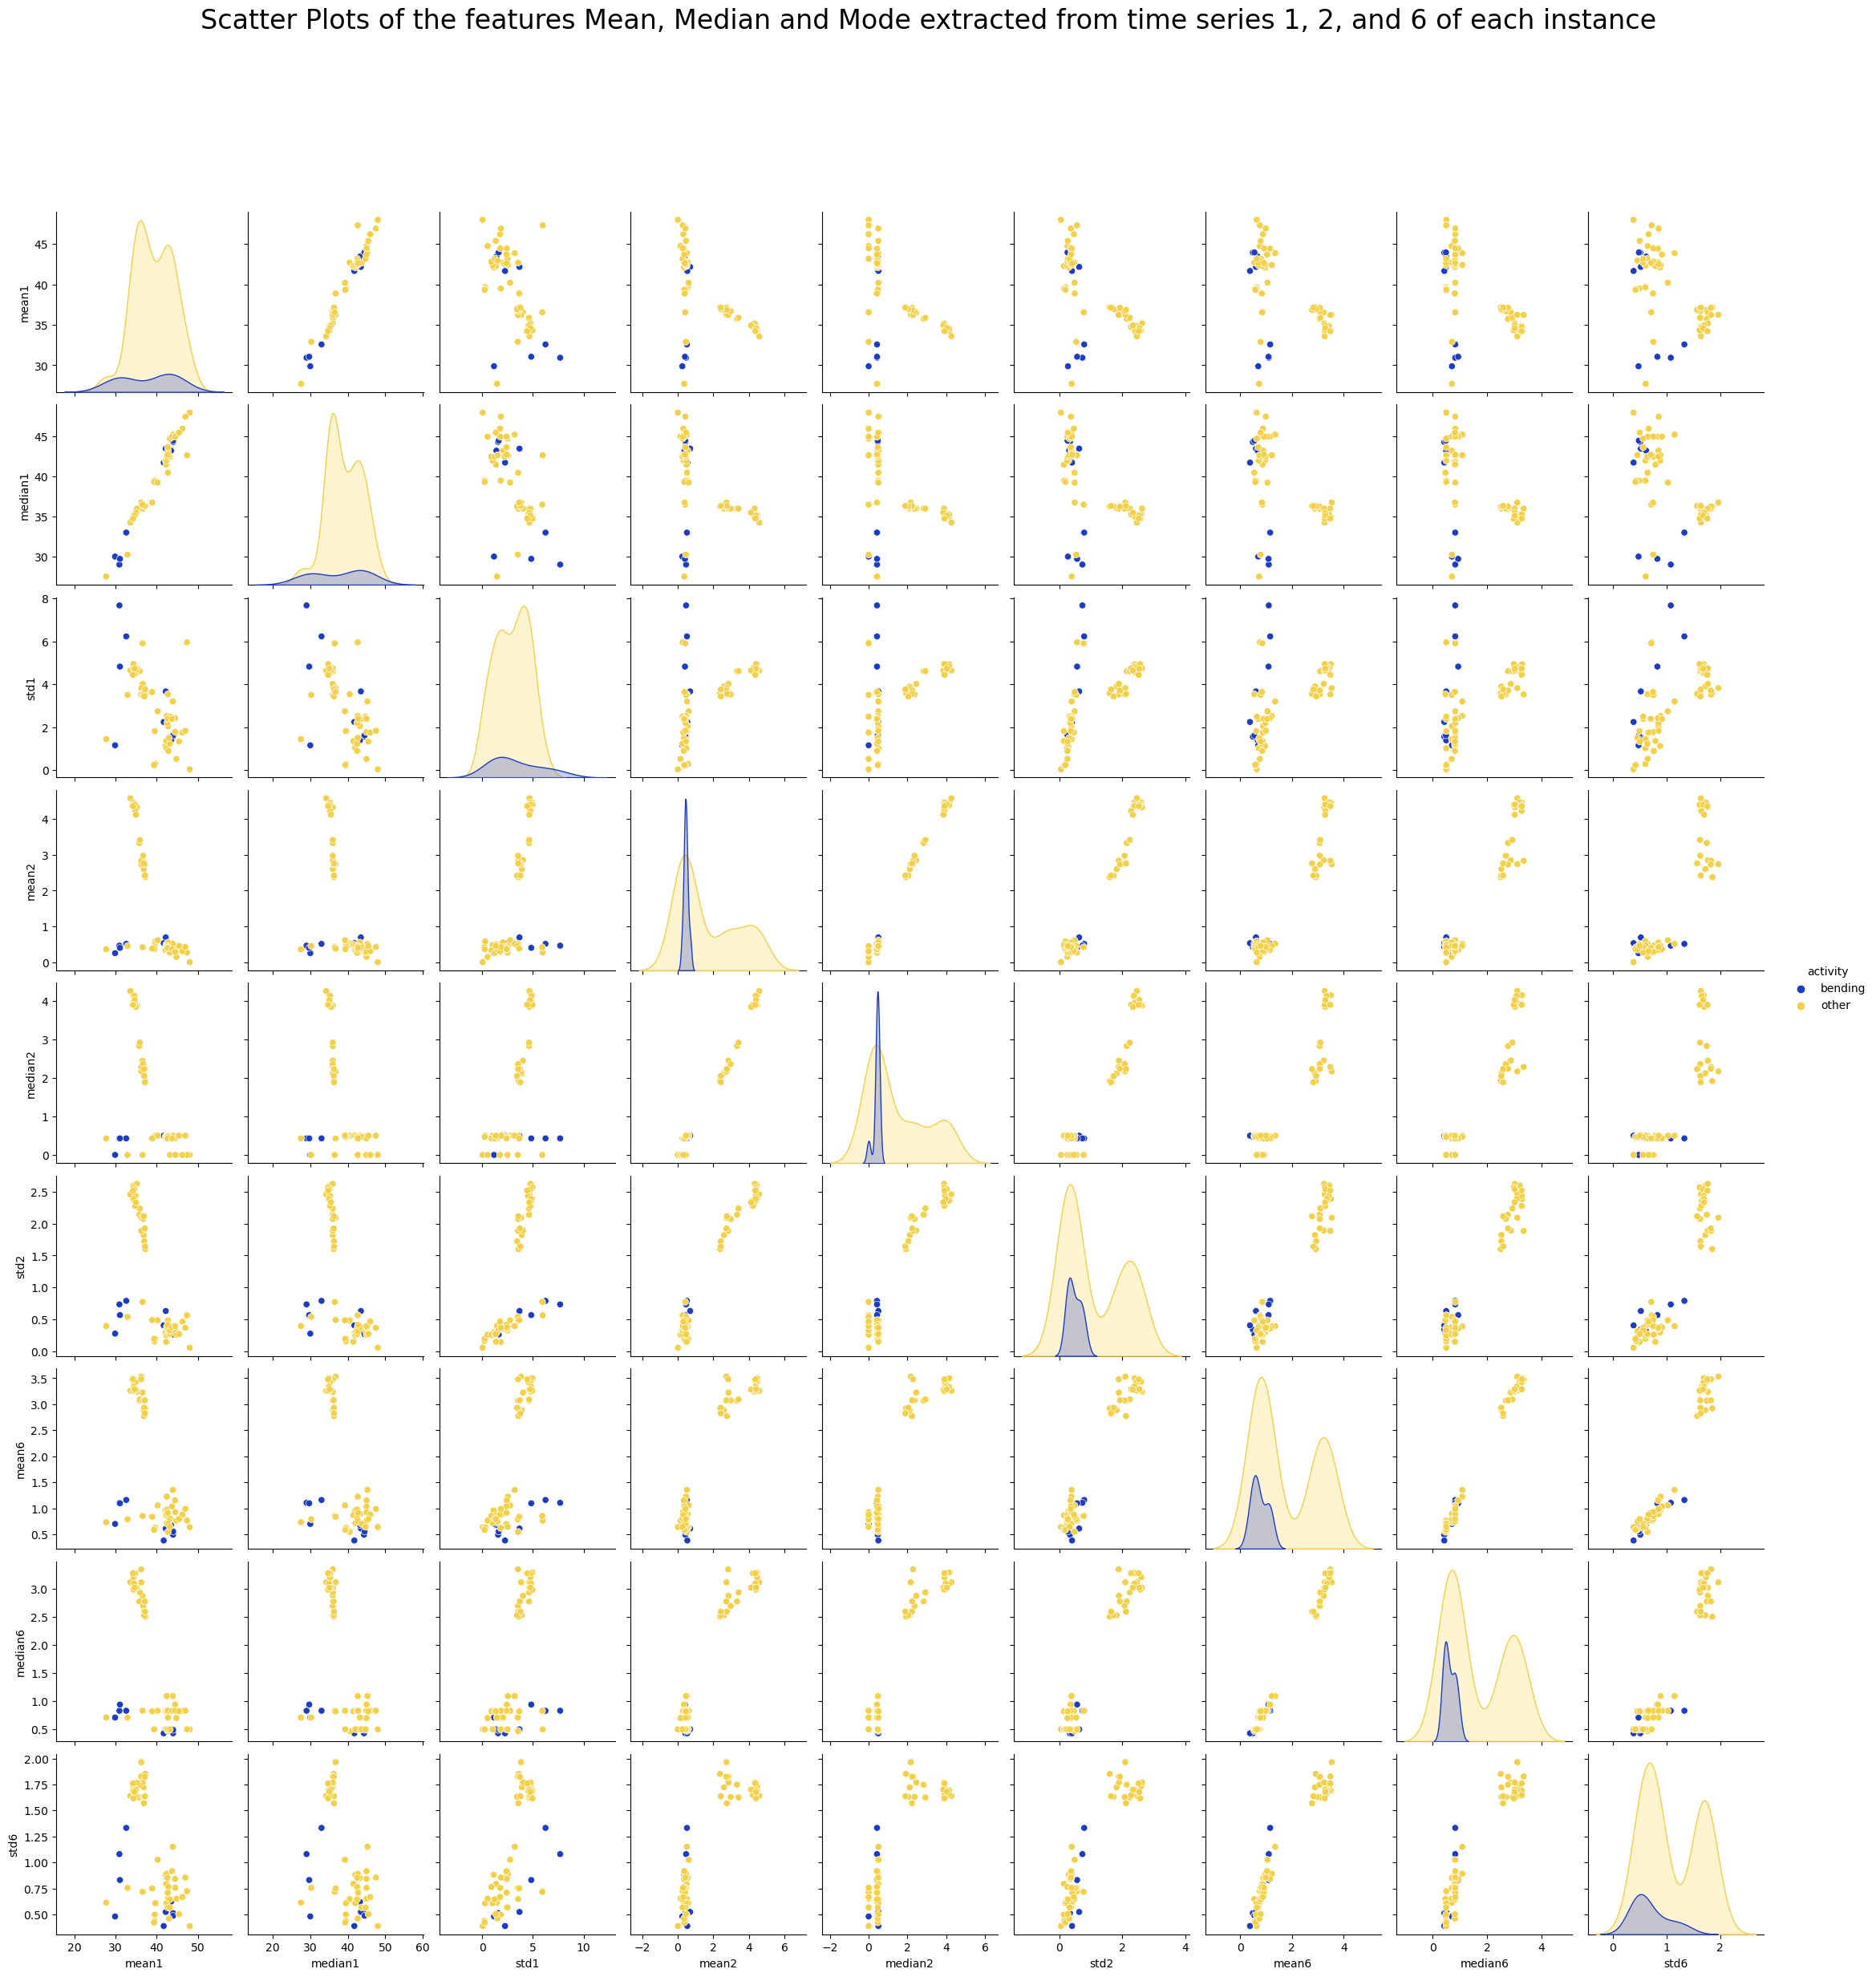

In [169]:
#giving a color pallette for the plots
identification_colors = ['#1b3bcc', '#F5D042']  
figure_plot=sns.pairplot(data=custom_train_df,hue='activity',palette=identification_colors)
figure_plot.fig.suptitle("Scatter Plots of the features Mean, Median and Mode extracted from time series 1, 2, and 6 of each instance", y=1.1, fontsize=24, verticalalignment='top')

In [170]:
def get_stats_per_df(df,label,train_or_test):
    new_column=[]
    old_data_columns=df.columns
    i=0
    for col in old_data_columns:
        new_column.append(i)
        i+=1
    df.columns=new_column
    min_=df.min()
    max_=df.max()
    mean_=df.mean()
    std_=df.std()
    median_=df.median()
    first_quartile=df.quantile(0.25)
    third_quartile=df.quantile(0.75)
    row=[]
    
    for col in df.columns:
        row.append(min_[col])
        row.append(max_[col])
        row.append(mean_[col])
        row.append(std_[col])
        row.append(median_[col])
        row.append(first_quartile[col])
        row.append(third_quartile[col])
    row.append(label)
    row.append(train_or_test)
    return row


In [171]:
def make_new_dataset_split_features(activity_dict,train_or_test,break_size):    
    col1=[str(x+1) for x in range(0,6*break_size)]
    col2=['min','max','mean','std','median','firstquartile','thirdquartile']
    new_col=[]
    for right in col1:
        for left in col2:
            new_col.append(left+right)
    new_col.append('activity')
    new_col.append('train/test')
    
    data_new=[]
    for key in activity_dict:
        for df in activity_dict[key]:
            df=df.drop(columns=df.columns[0]) 
            split_size=len(df)//break_size
            start,end=0,split_size
            arr=[]
            while(end<=len(df)):
                arr.append(df.iloc[start:end].reset_index())
                start=end
                end+=split_size
            new_df = pd.concat(arr,axis=1).drop(columns='index')
            data_new.append(get_stats_per_df(new_df,key,train_or_test))
    return pd.DataFrame(data_new,columns=new_col)
  

<h3>Q2. (a) ii. Break each time series in your training set into two (approximately) equal length time series. Now instead of 6 time series for each of the training instances, you have 12 time series for each training instance. Repeat the experiment in 2(a)i, i.e depict scatter plots of the features extracted from both parts of the time series 1,2, and 6. Do you see any considerable difference in the results with those of 2(a)i?</h3>

<p> <b>Scatter plots for bending vs other activites for chosen time series but split into two</b></p>

In [172]:
train_df_half_split=make_new_dataset_split_features(train_activity_dict,'train',2)
display(train_df_half_split)
train_df_half_split = train_df_half_split[bending_vs_other([1,2,6,7,8,12], ['mean','median','std'])].copy()
train_df_half_split['activity'] = train_df_half_split['activity'].apply(lambda x :'bending' if x =='bending1' or x=='bending2' else 'other')

test_df_half_split=make_new_dataset_split_features(test_activity_dict,'train',2)
test_df_half_split = test_df_half_split[bending_vs_other([1,2,6,7,8,12], ['mean','median','std'])].copy()
test_df_half_split['activity'] = test_df_half_split['activity'].apply(lambda x :'bending' if x =='bending1' or x=='bending2' else 'other')



min1   max1      mean1      std1  median1  firstquartile1  \
0   36.50  46.50  44.057167  1.556971   44.500         43.2500   
1   33.75  47.75  43.278875  3.473355   45.000         42.0000   
2   33.00  45.75  41.621208  3.118644   42.330         39.6525   
3   39.00  48.00  44.117042  1.359836   45.000         43.5000   
4   36.67  45.00  43.486208  1.281976   43.710         42.3300   
..    ...    ...        ...       ...      ...             ...   
64  22.33  46.00  34.966250  4.733014   35.500         32.0000   
65  21.50  45.67  34.737042  4.276717   35.500         32.0000   
66  18.33  45.00  33.886458  5.143776   34.375         30.4575   
67  18.33  44.00  34.836458  4.869092   35.750         32.0000   
68  23.00  42.75  34.329333  4.549837   34.710         31.3100   

    thirdquartile1  min2   max2     mean2  ...  thirdquartile11  min12  max12  \
0          45.0000   0.0   1.50  0.381042  ...          36.2500   0.00   1.50   
1          45.2500   0.0   3.00  0.673292  ...          33.7500   0.00   2.18   
2          44.2500   0.0   2.83  0.623083  ...          30.5625   0.00   1.50   
3          45.0000   0.0   1.30  0.250042  ...          23.7500   0.00   4.06   
4          44.5000   0.0   1.30  0.378667  ...          23.5000   0.00   2.96   
..             ...   ...    ...       ...  ...              ...    ...    ...   
64         38.7500   0.0  12.68  4.207958  ...          18.5000   0.00   9.39   
65         37.7500   0.0  12.21  4.217333  ...          18.2500   0.00  10.21   
66         37.5000   0.0  12.44  4.332208  ...          18.2500   0.00   8.01   
67         38.6900   0.0  12.38  4.257750  ...          18.2500   0.47   8.84   
68         37.5425   0.0  14.50  4.315917  ...          18.0000   0.43   9.12   

      mean12     std12  median12  firstquartile12  thirdquartile12  activity  \
0   0.388333  0.478528     0.000           0.0000           0.7100  bending1   
1   0.586083  0.491873     0.470           0.0000           0.8700  bending1   
2   0.347500  0.363144     0.430           0.0000           0.5000  bending1   
3   0.543875  0.473445     0.500           0.4300           0.7100  bending1   
4   0.585750  0.487918     0.500           0.4225           0.8300  bending1   
..       ...       ...       ...              ...              ...       ...   
64  3.430208  1.647979     3.350           2.1700           4.4400   walking   
65  3.225917  1.665326     3.085           2.0500           4.3500   walking   
66  3.274750  1.670593     2.955           2.0500           4.4375   walking   
67  3.409458  1.707089     3.110           2.1700           4.3450   walking   
68  3.577833  1.794112     3.290           2.2900           4.7250   walking   

    train/test  
0        train  
1        train  
2        train  
3        train  
4        train  
..         ...  
64       train  
65       train  
66       train  
67       train  
68       train  

[69 rows x 86 columns]

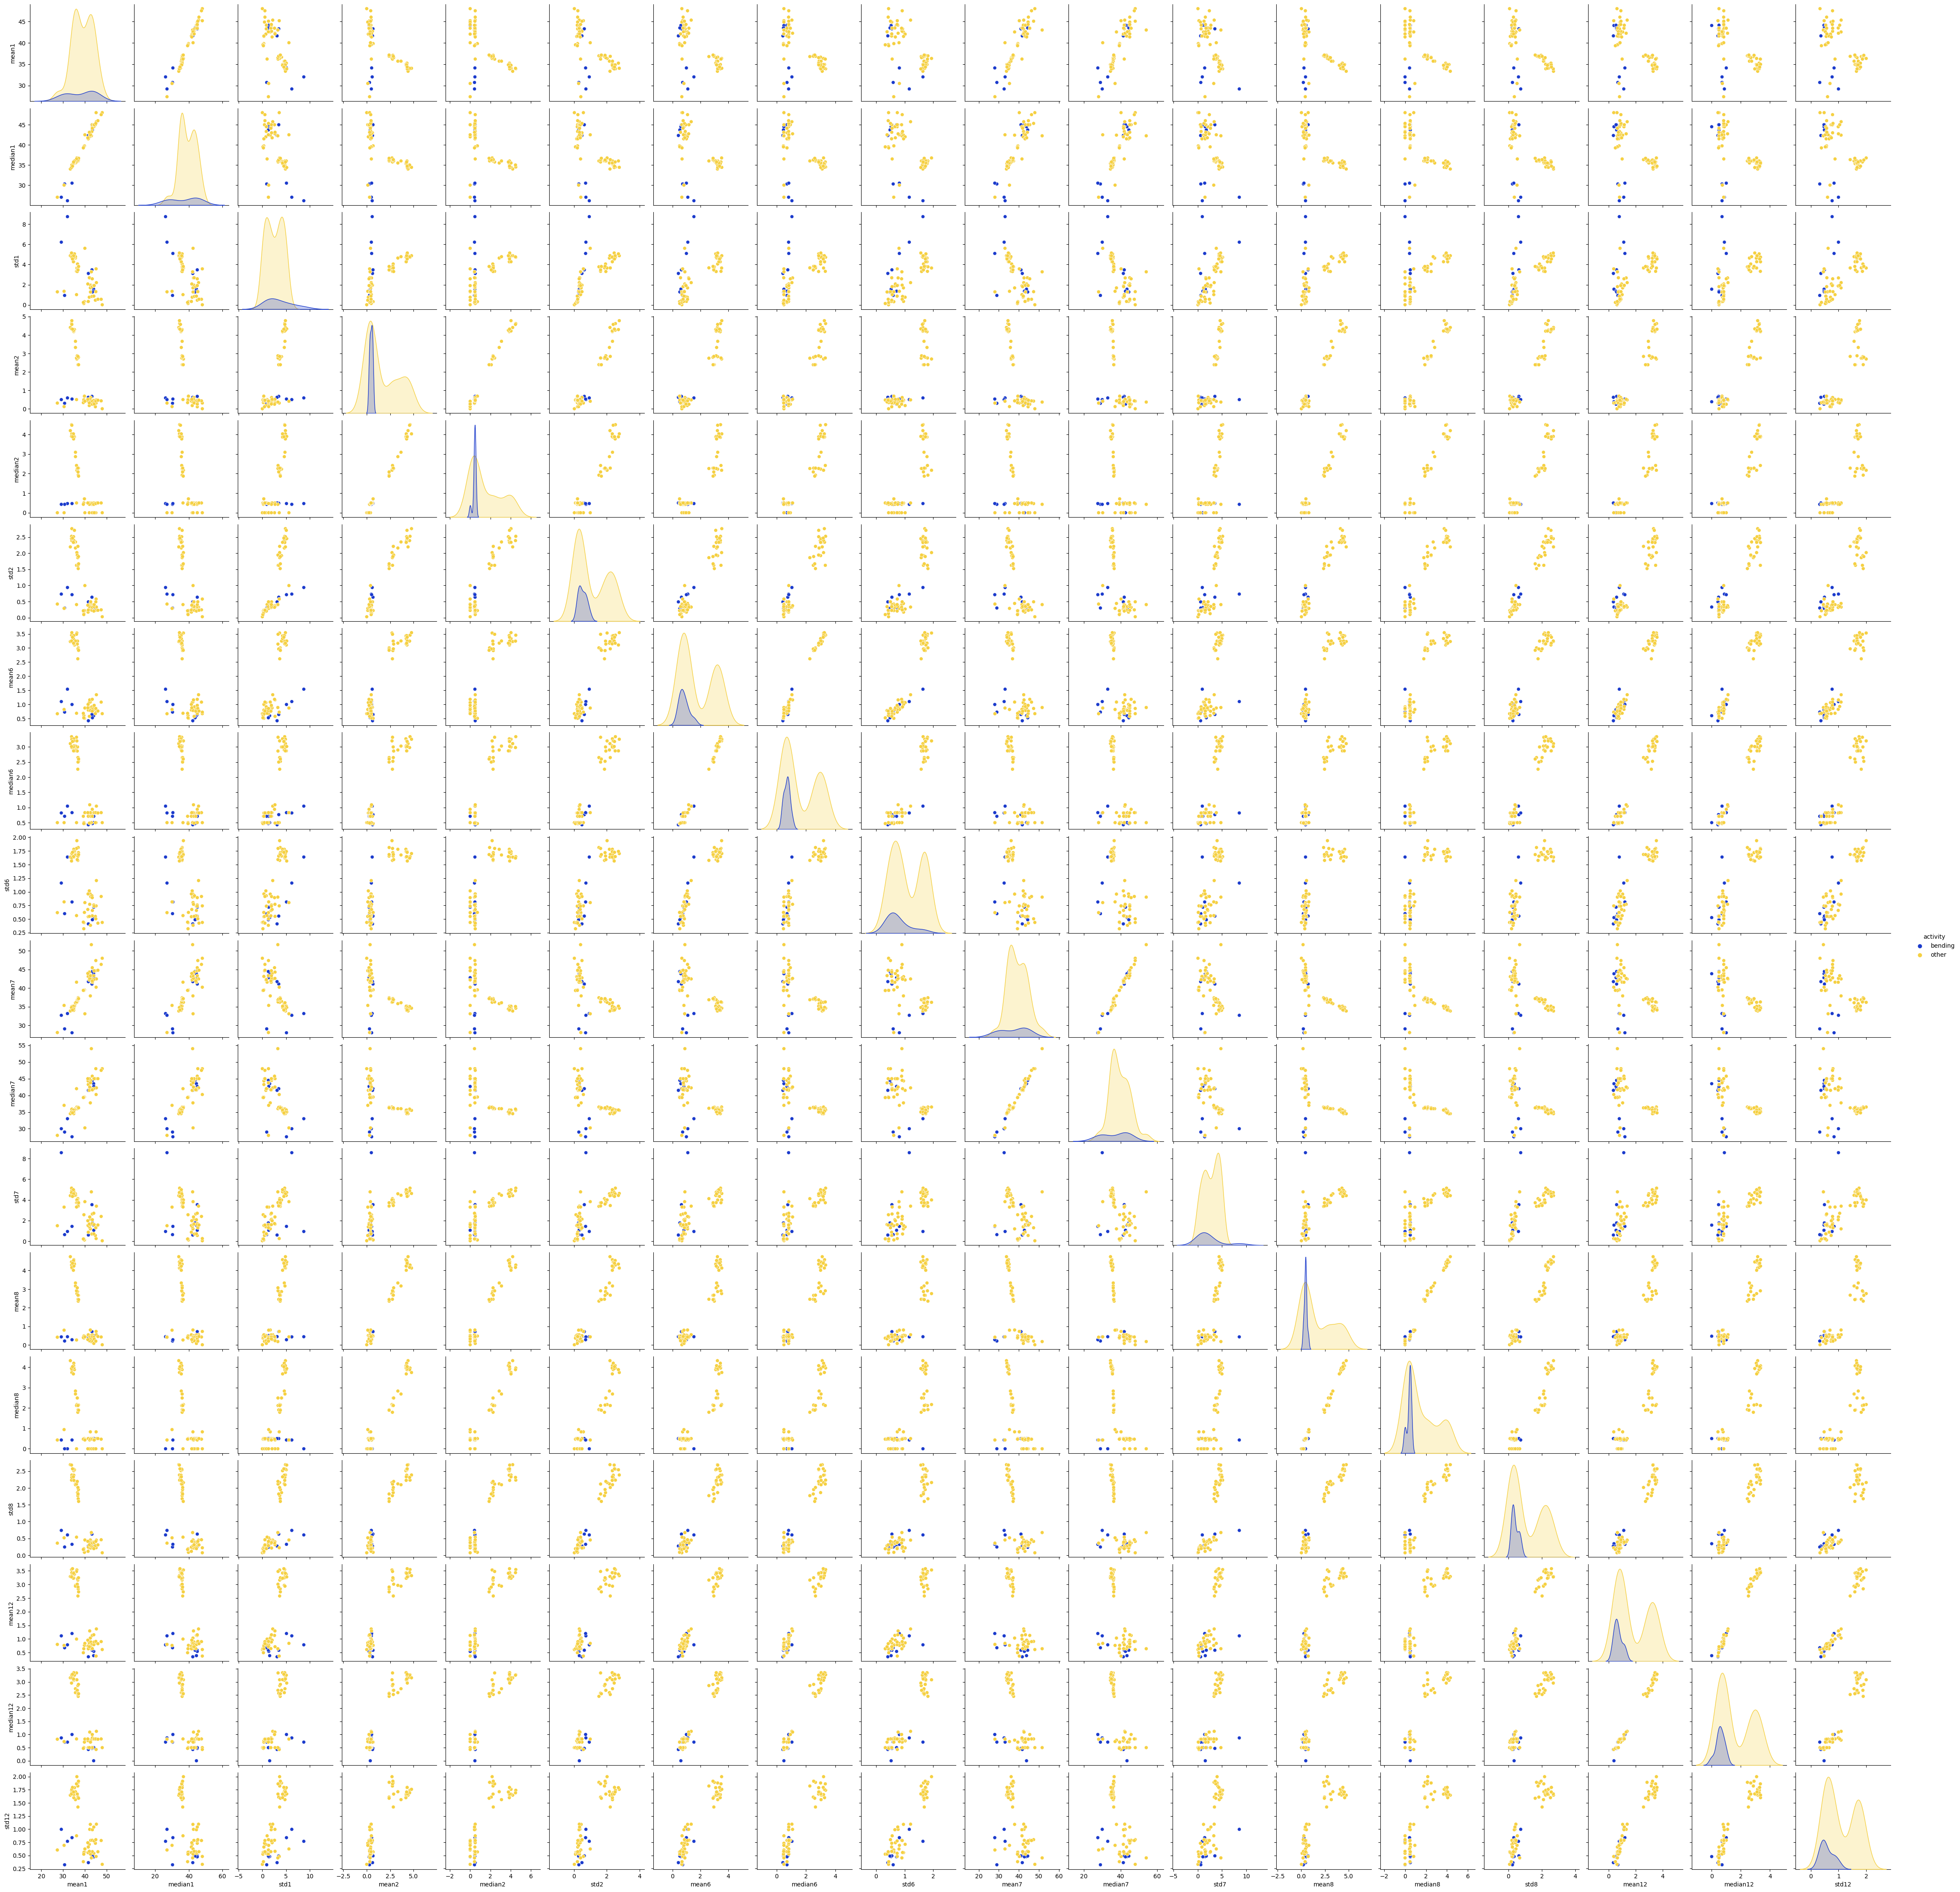

In [173]:
sns.pairplot(data=train_df_half_split,hue='activity',palette=identification_colors)

<h3>Observation:</h3>
<p><font size="4">Comparing the scatter plot we got in Q2. (a) i. with the above scatter plot in Q2. (a) ii. We can say that, there is not a lot of considerable difference between the two scatter plots constructed. They both show a similar curve for the time series values.</font></p>

<h3>Q2. (a) iii. Break each time series in your training set into l ∈ { 1,2, . . . ,20} time series of approximately equal length and use logistic regression  to solve the binary classification problem, using time-domain features </h3>

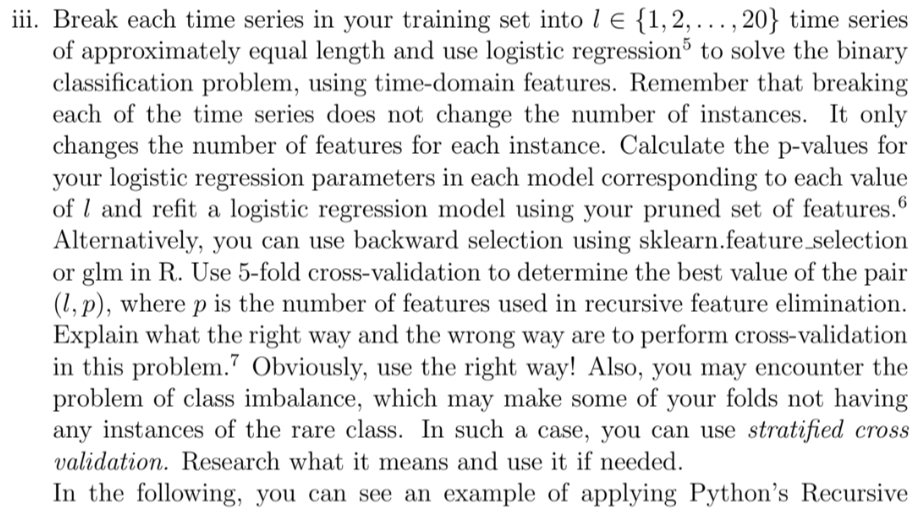

<p>Logistic Regression with pruned features and split time series</p>

In [174]:
def oversample_data_set(data_set):
    zero_labels = data_set.loc[data_set['activity'] == 0].shape[0]
    one_labels = data_set.loc[data_set['activity'] == 1].shape[0]
    minor_count = min(zero_labels, one_labels)
    major_count = max(zero_labels, one_labels)
    if zero_labels > one_labels:
        minor_label = 1
        major_label = 0
    else:
        minor_label = 0
        major_label = 1
        
    minor_df = data_set[data_set['activity'] == minor_label]
    major_df = data_set[data_set['activity'] == major_label]
    minor_df = resample(minor_df, replace=True, random_state=42, n_samples=max(zero_labels, one_labels))
    res_df = pd.concat([major_df, minor_df])
    return res_df

In [175]:

def optimalPruning(model,oversampling=False):
    
    res = {
    'L' :[],
    'p' :[],
    'score': [],
    'chosen features' : []
    }
    
    for l in range(1,21):
        
        rfe=RFECV(model,cv=StratifiedKFold(n_splits=5, shuffle = True, random_state = 42),scoring='accuracy')
        train_df_custom_split = make_new_dataset_split_features(train_activity_dict,'train',l)
        col_index=[str(x) for x in range(1,l*6+1)]
        new_cols=bending_vs_other(col_index, ['mean','median','std'])
        train_df_custom_split['activity'] = train_df_custom_split['activity'].apply(lambda x: 1 if x=='bending1' or x=='bending2' else 0)
        if oversampling:
            train_df_custom_split = oversample_data_set(train_df_custom_split)
        x,y = train_df_custom_split[new_cols[:-1]],train_df_custom_split['activity']
        rfe.fit(x,y)
        chosen_cols=[]

        for i in range(0,len(x.columns)):
            if rfe.support_[i]:
                chosen_cols.append(x.columns[i])       
        nf = rfe.n_features_
        score = rfe.cv_results_['mean_test_score'].max()
        res['L'].append(l)
        res['p'].append(nf)
        res['score'].append(round(score, 4))
        res['chosen features'].append(chosen_cols)

    return pd.DataFrame(res)

In [176]:
res_df = optimalPruning(LogisticRegression(penalty='l2', max_iter=100, solver = 'lbfgs'))
display(res_df)

L    p   score                                    chosen features
0    1    3  0.9571                             [median4, mean5, std5]
1    2   10  0.9429  [median3, median4, mean5, median5, std5, mean6...
2    3    1  0.9714                                            [mean5]
3    4    1  0.9571                                           [mean14]
4    5   21  0.9714  [mean5, median5, median7, mean8, mean9, mean11...
5    6   25  0.9714  [std3, mean5, median5, mean6, median6, mean11,...
6    7   13  0.9714  [median3, mean5, median5, mean11, median11, me...
7    8   29  0.9571  [median4, mean5, median5, mean11, median11, me...
8    9   10  0.9857  [mean5, median5, median9, mean11, median11, me...
9   10    1  0.9571                                           [mean11]
10  11    1  0.9714                                         [median11]
11  12    5  0.9714          [mean11, median11, std37, mean43, mean65]
12  13    6  0.9857  [mean11, median11, mean23, std25, mean43, mean71]
13  14    1  0.9714                                           [mean11]
14  15  179  0.9857  [mean2, median2, mean4, mean5, median5, std5, ...
15  16    7  0.9714  [mean11, mean17, median17, median29, std49, me...
16  17   10  0.9714  [mean11, median11, mean17, median17, mean29, s...
17  18   21  0.9714  [std7, mean11, median11, std13, mean17, median...
18  19  132  0.9703  [mean5, median5, std5, mean6, std7, median10, ...
19  20    1  0.9714                                           [mean17]

In [177]:

max_score_row = res_df.loc[res_df['score'].idxmax()]


print(f"Highest Score: {max_score_row['score']}")
print(f"Corresponding L value: {max_score_row['L']}")
print(f"Corresponding p value: {max_score_row['p']}")
print(f"Chosen Features: {max_score_row['chosen features']}")


Highest Score: 0.9857
Corresponding L value: 9
Corresponding p value: 10
Chosen Features: ['mean5', 'median5', 'median9', 'mean11', 'median11', 'mean17', 'median17', 'std25', 'mean31', 'median45']


<h4></h4>
<p>The optimal pair for analysis <b>(l,p) is (9, 10)</b>, and the chosen features for this examination are mean, median, and standard deviation.

We do not want to deprive our algorithm of the knowledge of potential predictors (and their potentially good combinations) that can be utilized. Therefore, the best approach is to combine and use Recursive Feature Elimination (RFE) along with Cross-Validation. Doing RFE before cross-validation would be the wrong way.<br><br> Moreover, it's crucial to split the data into training and testing sets before starting cross-validation. This means we only perform cross-validation on the training data, which gets further divided into smaller sets for training and validation, ensuring the test data remains unseen. Selecting the best features and models this way and then evaluating them against the test data at the end prevents overfitting and maintains the model's ability to perform well on new data, avoiding any premature exposure to the test data.</p>

<h3>Q2. (a) iv. Report the confusion matrix and show the ROC and AUC for your classifier on train data. Report the parameters of your logistic regression βi’s as well as the p-values associated with them</h3>

<p>Confusion matrix, ROC and AUC construction</p>

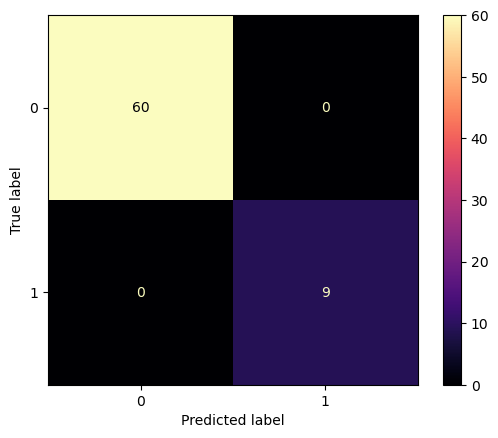

In [178]:
best_features = []
best_score = -1
best_l = 0
for i, data in res_df.iterrows():
    if(data['score']>best_score):
        best_features = data['chosen features']
        best_score = data['score']
        best_l = data['L']       
best_lp_data=make_new_dataset_split_features(train_activity_dict,'train',best_l)
x_train = best_lp_data.loc[:, best_features]
y_train = best_lp_data['activity'].apply(lambda x: 1 if x=='bending1' or x=='bending2' else 0)
x_train=sm.add_constant(x_train)
best_lp_model = sm.Logit(y_train, x_train).fit(method='lbfgs')
y_pred_raw=best_lp_model.predict(x_train)
y_pred=round(y_pred_raw)
disp=ConfusionMatrixDisplay(confusion_matrix(y_train,y_pred))
disp.plot(cmap='magma')
plt.show()


In [179]:
print('Train Accuracy = ',accuracy_score(y_train,y_pred))

Train Accuracy =  1.0


In [180]:
best_lp_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               activity   No. Observations:                   69
Model:                          Logit   Df Residuals:                       58
Method:                           MLE   Df Model:                           10
Date:                Sat, 02 Mar 2024   Pseudo R-squ.:                   1.000
Time:                        19:47:00   Log-Likelihood:            -8.6999e-05
converged:                       True   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 6.181e-08
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0911   5.01e+04  -1.82e-06      1.000   -9.82e+04    9.82e+04
mean5          0.7208   1.68e+04    4.3e-05      1.000   -3.29e+04    3.29e+04
median5        0.5646   1.19e+04   4.74e-05      1.000   -2.34e+04    2.34e+04
median9       -0.9033   2434.742     -0.000      1.000   -4772.909    4771.103
mean11         1.3772   5634.914      0.000      1.000    -1.1e+04     1.1e+04
median11       1.7143   5261.841      0.000      1.000   -1.03e+04    1.03e+04
mean17         0.7615   2486.448      0.000      1.000   -4872.586    4874.109
median17       0.6539   4350.135      0.000      1.000   -8525.454    8526.762
std25         -0.5502   4546.390     -0.000      1.000   -8911.311    8910.211
mean31        -2.2725   2387.192     -0.001      0.999   -4681.083    4676.538
median45      -1.2330   1262.936     -0.001      0.999   -2476.543    2474.077
==============================================================================

Complete Separation: The results show that there iscomplete separation or perfect prediction.
In this case the Maximum Likelihood Estimator does not exist and the parameters
are not identified.
"""

<h3>Observation:</h3>
<p>Through p-value analysis, data is completely seperated. Since logistic regression generally has this error when data is seperated, we cannot rely on p-value estimates.</p>

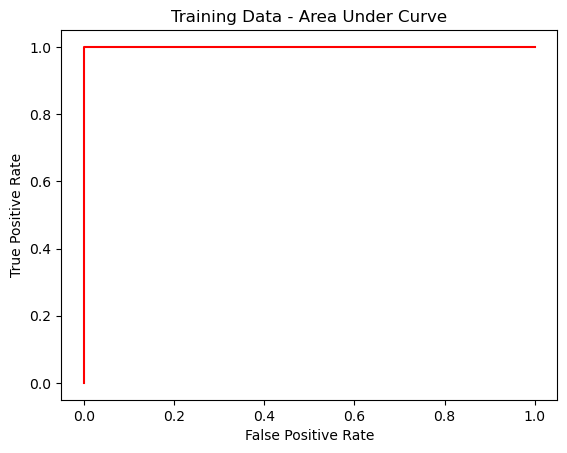

Train Area Under Curve is :  1.0


In [181]:

def plot_roc_and_print_auc(y_true, y_scores, plot_color='red', title='Training Data - Area Under Curve'):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    plt.plot(fpr, tpr, color=plot_color)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.show()
    auc_score = roc_auc_score(y_true, y_scores)
    print('Train Area Under Curve is : ', auc_score)

plot_roc_and_print_auc(y_train, y_pred_raw, plot_color='red')



<h3>Q2. (a) v. Test the classifier on the test set. Remember to break the time series in your test set into the same number of time series into which you broke your training set. Remember that the classifier has to be tested using the features extracted from the test set. Compare the accuracy on the test set with the cross-validation accuracy you obtained previously</h3>

<p>Testing classifier on test set</p>

In [182]:
test_data=make_new_dataset_split_features(test_activity_dict,'test',best_l)
x_test,y_test = test_data[best_features],test_data['activity'].apply(lambda x: 1 if x=='bending1' or x=='bending2' else 0)
x_test=sm.add_constant(x_test)

y_pred=best_lp_model.predict(x_test)
y_pred=(round(y_pred).values).astype(int)

print('Test accuracy on the test set = ', accuracy_score(y_test,y_pred))

Test accuracy on the test set =  0.9473684210526315


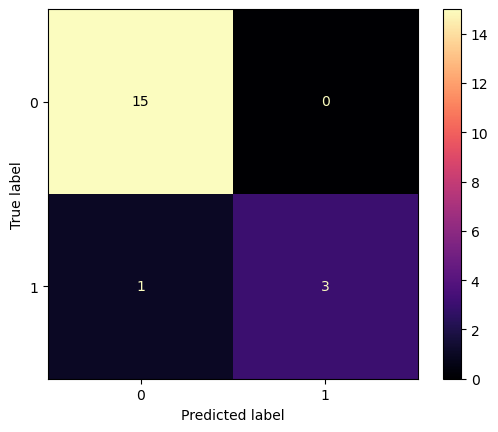

In [183]:

def plot_confusion_matrix(y_true, y_pred, colormap='magma'):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=colormap)
    plt.show()

plot_confusion_matrix(y_test, y_pred, colormap="magma")



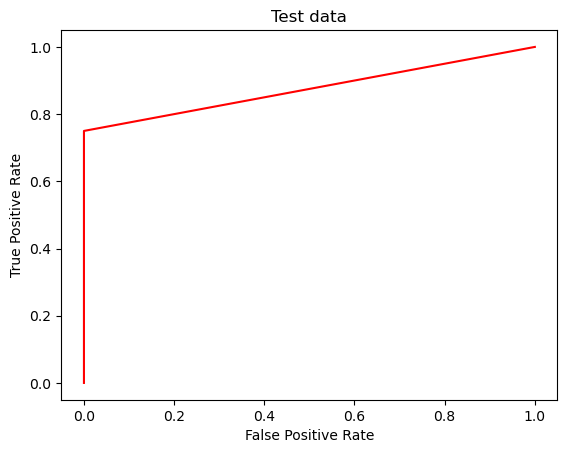

Test Area Under Curve is : 0.875


In [184]:


def plot_roc_curve_and_print_auc(y_true, y_scores, title='Test data', plot_color='red'):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    plt.plot(fpr, tpr, color=plot_color)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.show()
    auc_score = roc_auc_score(y_true, y_scores)
    print(f'Test Area Under Curve is : {auc_score}')


plot_roc_curve_and_print_auc(y_test, y_pred, title='Test data', plot_color='red')




<h3>Observation:</h3>
<p>The accuracy for test set is slightly lower than that in cross validation in my case.</p>

<h3>Q2. (a) vi. Do your classes seem to be well-separated to cause instability in calculating logistic regression parameters</h3>

<p>The calculation of logistic regression parameters exhibits instability due to the clear separation between the classes, leading to difficulties in determining the parameters through iterative methods. This issue is also highlighted as a warning when training the model with statsmodels. Under these conditions, accurately identifying the parameters becomes challenging. The findings indicate that the distinct separation between the classes could be contributing to the instability in calculating the regression parameters. To mitigate this issue, exploring regularization techniques or alternative modeling strategies might be required to enhance parameter estimation stability.</p>
<p>The p-value analysis via statmodel reveals complete separation.
Due to this, the maximum likelihood estimator is nonexistent, making it impossible to determine parameters.
This clear separation of classes leads to instability in computing regression parameters.</p>

<h3>Q2. (a) vii. From the confusion matrices you obtained, do you see imbalanced classes? If yes, build a logistic regression model based on case-control sampling and adjust its parameters. Report the confusion matrix, ROC, and AUC of the model.</h3>

<p>Treating imbalance and retraining data</p>
<p>We can see that there is a clear imbalance between the bending and non-bending classes based on the consfusion matrix. Hence it's necessary to develop a regression model based on case-controlled sampling, meaning oversampling is required.</p>

In [185]:
res_df = optimalPruning(LogisticRegression(penalty='l2', max_iter=100, solver = 'lbfgs'), oversampling=True)
display(res_df)

L   p   score                                    chosen features
0    1   6  0.9917      [mean1, mean2, median3, median4, mean5, std5]
1    2   8  0.9833  [median3, std3, median4, mean5, median5, std5,...
2    3   6  0.9917       [mean3, mean5, median5, mean7, std7, mean17]
3    4   9  0.9917  [std3, mean5, median5, mean12, median13, mean1...
4    5   6  0.9917  [mean5, median5, std13, mean19, median22, mean29]
5    6   9  1.0000  [median4, mean5, median5, mean11, median15, me...
6    7   6  0.9917  [median3, mean5, median5, mean11, median11, me...
7    8   4  0.9917                  [mean11, mean17, median25, std25]
8    9   4  0.9917                 [mean5, median9, mean11, median11]
9   10   4  0.9917               [mean11, median11, mean17, median31]
10  11   5  1.0000        [mean11, median11, std19, median37, mean59]
11  12   4  1.0000                  [mean11, median11, std37, mean65]
12  13  11  1.0000  [mean11, median11, mean23, median23, std25, me...
13  14   3  0.9917                         [mean11, median69, mean77]
14  15   5  1.0000           [mean11, mean17, mean49, mean75, mean83]
15  16  26  1.0000  [mean5, std7, mean11, median11, median15, mean...
16  17   4  1.0000                  [mean17, median17, std31, mean95]
17  18   4  1.0000                 [mean17, median17, std31, mean101]
18  19   6  0.9917  [mean17, median17, median35, mean67, median93,...
19  20   7  1.0000  [mean17, median17, mean23, mean35, std37, std6...

In [186]:
best_features = []
best_score = -1
best_l = 0
for i, data in res_df.iterrows():
    if(data['score']>best_score):
        best_features = data['chosen features']
        best_score = data['score']
        best_l = data['L']

print('\nThe best L and p values are:', best_l, len(best_features))
        



The best L and p values are: 6 9



Training dataset
------------------------------------------------------------



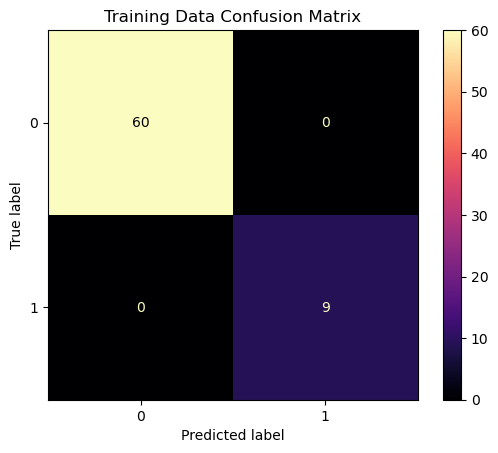

Train Accuracy = 1.0


In [187]:
print('\nTraining dataset')
print('------------------------------------------------------------\n')
best_lp_data=make_new_dataset_split_features(train_activity_dict,'train',int(best_l))
x_train = best_lp_data.loc[:, best_features]
y_train = best_lp_data['activity'].apply(lambda x: 1 if x=='bending1' or x=='bending2' else 0)
x_train=sm.add_constant(x_train)


best_lp_model = sm.Logit(y_train, x_train).fit(method='lbfgs')
y_train_pred_raw=best_lp_model.predict(x_train)
y_train_pred=round(y_train_pred_raw)


def display_confusion_matrix_and_accuracy(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="magma")
    plt.title(title)
    plt.show()
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Train Accuracy = {accuracy}')

display_confusion_matrix_and_accuracy(y_train, y_train_pred, title='Training Data Confusion Matrix')



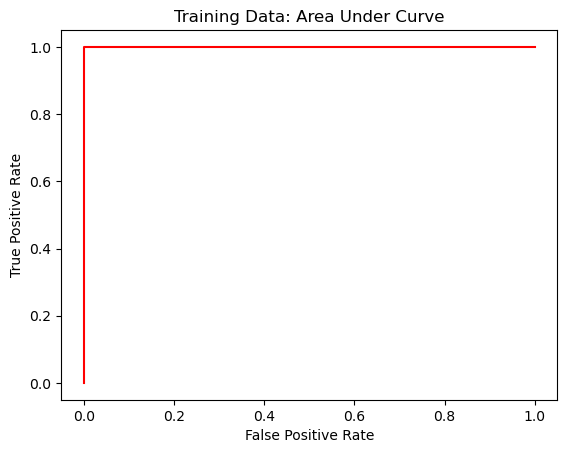

Train Area Under Curve is 1.0


In [188]:

def plot_roc_and_print_auc(y_true, y_scores, title='Training Data: Area Under Curve', line_color='red'):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    plt.plot(fpr, tpr, color=line_color)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.show()
    
    auc_score = roc_auc_score(y_true, y_scores)
    print(f'Train Area Under Curve is {auc_score}')


plot_roc_and_print_auc(y_train, y_train_pred_raw, title='Training Data: Area Under Curve', line_color='red')


Test dataset
----------------------------------------------------



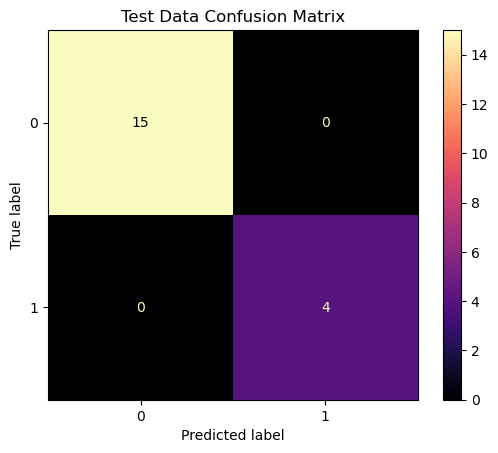

Test Accuracy is =  1.0


In [189]:

print('\nTest dataset')
print('----------------------------------------------------\n')
test_data=make_new_dataset_split_features(test_activity_dict,'test',best_l)
x_test,y_test = test_data[best_features],test_data['activity'].apply(lambda x: 1 if x=='bending1' or x=='bending2' else 0)
x_test=sm.add_constant(x_test)
y_test_pred_raw=best_lp_model.predict(x_test)
y_test_pred=round(y_test_pred_raw)


def display_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="magma")
    plt.title(title)
    plt.show()


display_confusion_matrix(y_test, y_test_pred, title='Test Data Confusion Matrix')

print('Test Accuracy is = ',accuracy_score(y_test,y_test_pred))



Test Area Under Curve is:  1.0


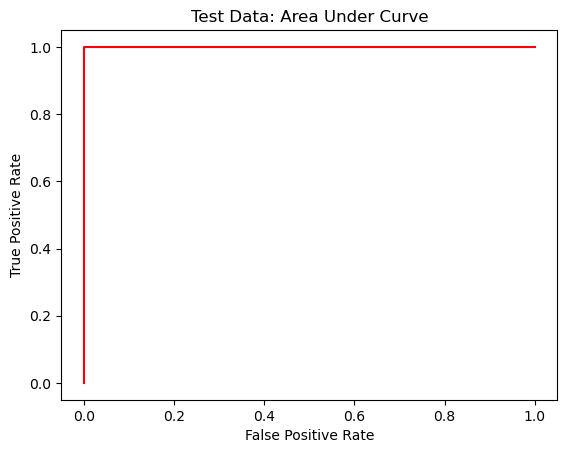

In [190]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_raw)
plt.plot(fpr, tpr, color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test Data: Area Under Curve')
print('Test Area Under Curve is: ',roc_auc_score(y_test,y_test_pred_raw))

<h3>Q2. (b) Binary Classification Using L1-penalized logistic regression</h3>

<h3>Q2. (b) i. Repeat 2(a)iii using L1-penalized logistic regression, i.e. instead of using p-values for variable selection, use L1 regularization. Note that in this problem, you have to cross-validate for both l , the number of time series into which you
break each of your instances, and λ, the weight of L1-penalty in your logistic regression objective function (or C, the budget). Packages usually perform cross-validation for λ automatically</h3>

In [191]:
res = {
    'L' :[],
    'score': []
    }
    
for l in range(1,21):
    train_df_custom_split = make_new_dataset_split_features(train_activity_dict,'train',l)
    col_index=[str(x) for x in range(1,l*6+1)]
    new_cols=bending_vs_other(col_index, ['mean','median','std'])
    train_df_custom_split['activity'] = train_df_custom_split['activity'].apply(lambda x: 1 if x=='bending1' or x=='bending2' else 0)
    x,y = train_df_custom_split[new_cols[:-1]],train_df_custom_split['activity']
    scaler = StandardScaler().fit(x)
    x=scaler.transform(x)
    l1_model=LogisticRegressionCV(cv=5,penalty='l1',solver='liblinear',random_state=42,max_iter=100)
    l1_model.fit(x,y)
    res['L'].append(l)
    res['score'].append(l1_model.score(x,y))

res_df = pd.DataFrame(res)
display(res_df)

L     score
0    1  0.956522
1    2  1.000000
2    3  0.971014
3    4  0.971014
4    5  1.000000
5    6  1.000000
6    7  0.971014
7    8  1.000000
8    9  0.971014
9   10  1.000000
10  11  1.000000
11  12  1.000000
12  13  0.971014
13  14  1.000000
14  15  0.985507
15  16  1.000000
16  17  1.000000
17  18  1.000000
18  19  1.000000
19  20  1.000000

In [192]:
def print_confusion_matrix(y_true,y_pred,title):
    disp=ConfusionMatrixDisplay(confusion_matrix(y_true,y_pred))
    disp.plot(cmap="magma")
    plt.title(title)
    plt.show()

def make_roc_curve(y_train,y_pred_raw,title):
    fpr, tpr, thresholds = roc_curve(y_train, y_pred_raw)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    print('Area Under Curve =',roc_auc_score(y_train,y_pred_raw))

In [193]:
best_score = -1
best_l = 0
for i, data in res_df.iterrows():
    if(data['score']>best_score):
        best_score = data['score']
        best_l = data['L']

print('Best L value is :', int(best_l))

Best L value is : 2


For Training Data:
------------------------------------------

Accuracy= 1.0


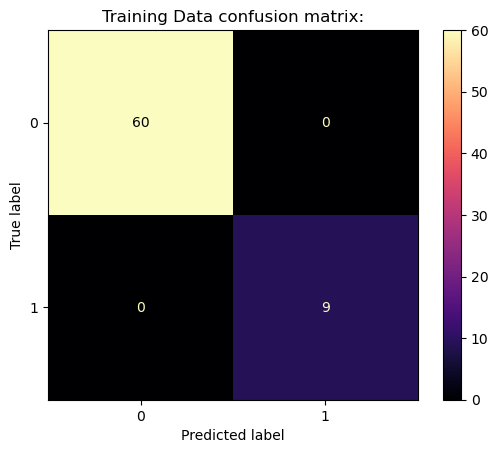

Area Under Curve = 1.0


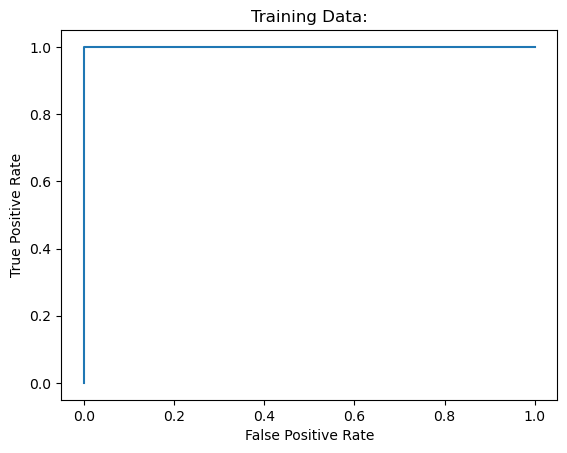

In [194]:


print('For Training Data:')
print('------------------------------------------\n')
best_l_data=make_new_dataset_split_features(train_activity_dict,'train',int(best_l))
col_index=[str(x) for x in range(1,int(best_l)*6+1)]
new_cols=bending_vs_other(col_index, ['mean','median','std'])
x_train,y_train= best_l_data[new_cols[:-1]],best_l_data['activity'].apply(lambda x: 1 if x=='bending1' or x=='bending2' else 0) 
x_train=sm.add_constant(x_train)


best_l_model = sm.Logit(y_train, x_train).fit(method='lbfgs')
y_pred_raw_train=best_l_model.predict(x_train)
y_pred=round(y_pred_raw_train)

print('Accuracy=',accuracy_score(y_train,y_pred))
print_confusion_matrix(y_train,y_pred,'Training Data confusion matrix:')
make_roc_curve(y_train,y_pred_raw_train,'Training Data:')





For Testing Data:
------------------------------------------

Accuracy= 1.0


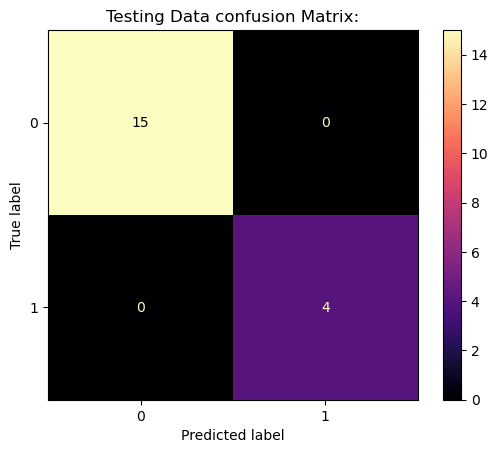

Area Under Curve = 1.0


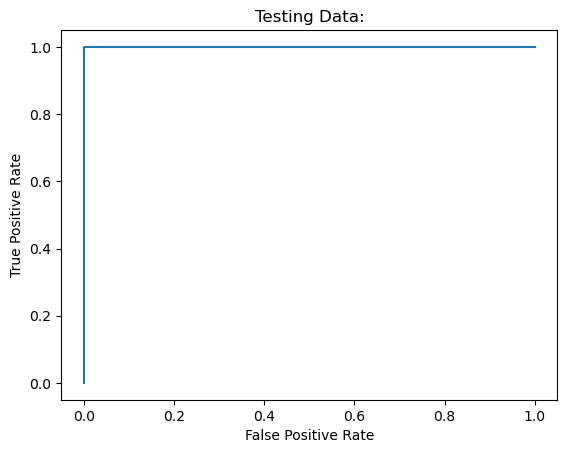

In [195]:
print('For Testing Data:')
print('------------------------------------------\n')
best_l_data=make_new_dataset_split_features(test_activity_dict,'test',int(best_l))
col_index=[str(x) for x in range(1,int(best_l)*6+1)]
new_cols=bending_vs_other(col_index, ['mean','median','std'])
x_test,y_test=best_l_data[new_cols[:-1]],best_l_data['activity'].apply(lambda x: 1 if x=='bending1' or x=='bending2' else 0)
x_test=sm.add_constant(x_test)

y_pred_raw_test=best_l_model.predict(x_test)
y_pred=round(y_pred_raw_test)

print('Accuracy=',accuracy_score(y_test,y_pred))
print_confusion_matrix(y_test,y_pred,'Testing Data confusion Matrix:')
make_roc_curve(y_test,y_pred_raw_test,'Testing Data:')

<h3>Q2. (b) ii. Compare the L1-penalized with variable selection using p-values. Which one performs better? Which one is easier to implement? </h3>

<p> Implementing L1 penalization is simpler than selecting variables based on p-values because it automates the feature selection process. In terms of execution speed and accuracy on test data, L1 penalization outperforms the method of selecting variables through p-values, offering quicker and more accurate results. Additionally, this approach often results in a more parsimonious model, enhancing interpretability without compromising predictive power.</p>

<h3>Q2. (c) Multi-class Classification (The Realistic Case)<h3>

<h3>Q2. (c) i. Find the best l in the same way as you found it in 2(b)i to build an L1-penalized multinomial regression model to classify all activities in your training set. Report your test error. Research how confusion matrices and ROC curves are defined for multiclass classification and show them for this problem if possible.</h3>

In [196]:
def get_best_l(model, model_name):
    res = {
        'L' :[],
        'score': []
        }

    for l in range(1,21):

        all_data=make_new_dataset_split_features(train_activity_dict,'train',l)
        col_index=[str(x) for x in range(1,l*6+1)]
        new_cols=bending_vs_other(col_index, ['mean','median','std'])
        x = all_data[new_cols[:-1]]
        all_data['activity']= all_data['activity'].apply(lambda x:x if x not in ['bending1','bending2'] else 'bending')
        y=all_data['activity']
        
        if(model_name =='lg'):
            scaler = StandardScaler().fit(x)
            x=scaler.transform(x)
        model.fit(x,y)

        res['L'].append(l)
        res['score'].append(model.score(x,y))

    res_df = pd.DataFrame(res)
    display(res_df)    
    return res_df

In [197]:
def plot_roc_curve(y, y_pred_prob, model):
    fig, axes = plt.subplots(figsize=(12, 7))
    axes.set_title("ROC curves")
    for i, cl in enumerate(model.classes_):
        y_pred = y_pred_prob[:, i]
        fpr, tpr, thresholds = roc_curve(y, y_pred, pos_label=cl)
        roc_auc = auc(fpr, tpr)
        axes.plot(fpr, tpr, label=f"Class: {cl}; ROC Curve Area: {round(roc_auc, 4)}")
    axes.plot([0, 1], [0, 1], "--")
    axes.set_xlabel("False Positive Rate")
    axes.set_ylabel("True Positive Rate")
    axes.legend()
    plt.show()

In [198]:
def model_runner(model, model_name, res_df):

    best_score = -1
    best_l = 0
    for i, data in res_df.iterrows():
        if(data['score']>best_score):
            best_score = data['score']
            best_l = data['L']

    best_l = int(best_l)
    print("Best L value is : "+ str(best_l))
    temp_data=make_new_dataset_split_features(train_activity_dict,'train',int(best_l))
    col_index=[str(x) for x in range(1,int(best_l)*6+1)]
    new_cols=bending_vs_other(col_index, ['mean','median','std'])

    x_train,y_train=temp_data[new_cols[:-1]],temp_data['activity'].apply(lambda x:x if x not in ['bending1','bending2'] else 'bending')

    temp_data=make_new_dataset_split_features(test_activity_dict,'test',int(best_l))

    x_test,y_test=temp_data[new_cols[:-1]],temp_data['activity'].apply(lambda x:x if x not in ['bending1','bending2'] else 'bending')

    if(model_name =='lg'):
        scaler = StandardScaler().fit(x_train)
        x_train=scaler.transform(x_train)
        scaler = StandardScaler().fit(x_test)
        x_test=scaler.transform(x_test)

    best_l_model = model
    best_l_model.fit(x_train,y_train)
    y_train_pred_prob = best_l_model.predict_proba(x_train)
    y_test_pred_prob = best_l_model.predict_proba(x_test)
    y_train_pred = best_l_model.predict(x_train)
    y_test_pred = best_l_model.predict(x_test)


    print("Training Data ROC:")
    plot_roc_curve(y_train, y_train_pred_prob, best_l_model)

    disp=ConfusionMatrixDisplay(confusion_matrix(y_train,y_train_pred))
    disp.plot(cmap="magma")
    plt.title('Training Data Confusion Matrix')
    plt.show()

    print("Tesingt Data ROC:")
    plot_roc_curve(y_test, y_test_pred_prob, best_l_model)

    disp=ConfusionMatrixDisplay(confusion_matrix(y_test,y_test_pred))
    disp.plot()
    plt.title('Testing Data Confusion Matrix')
    plt.show()
    
    print('Testing Error : ',1-accuracy_score(y_test,y_test_pred))




<h4>Multinomial Regression</h4>


Multinomial Regression with Standardization

-------------------------------------------------------



L     score
0    1  0.985507
1    2  1.000000
2    3  1.000000
3    4  1.000000
4    5  1.000000
5    6  1.000000
6    7  1.000000
7    8  0.985507
8    9  1.000000
9   10  1.000000
10  11  0.985507
11  12  1.000000
12  13  1.000000
13  14  1.000000
14  15  0.985507
15  16  1.000000
16  17  0.985507
17  18  1.000000
18  19  1.000000
19  20  1.000000

Best L value is : 2
Training Data ROC:


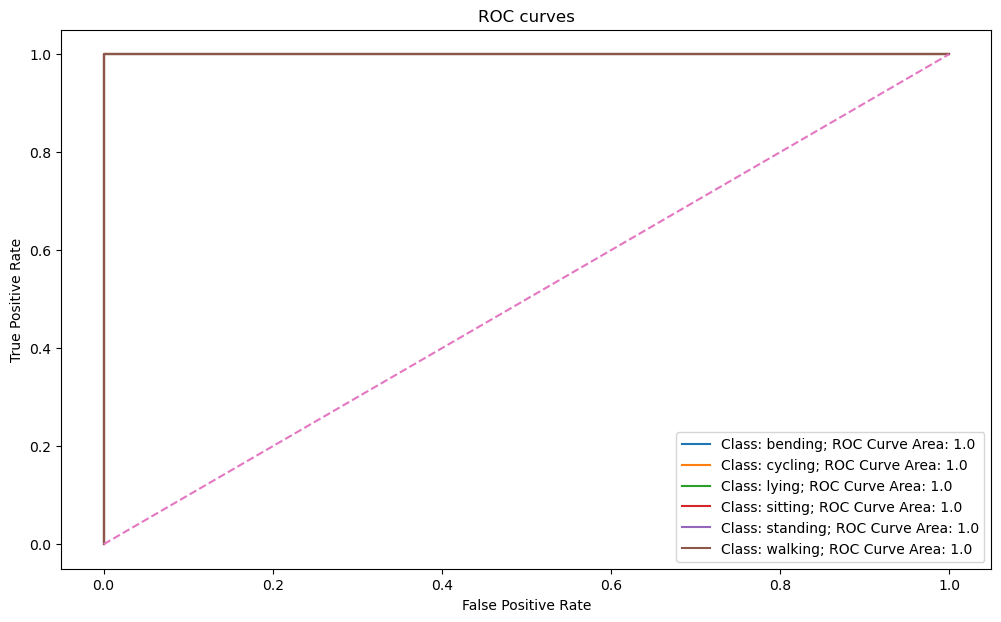

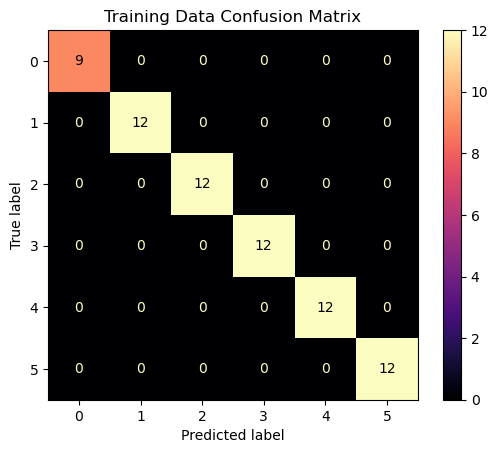

Tesingt Data ROC:


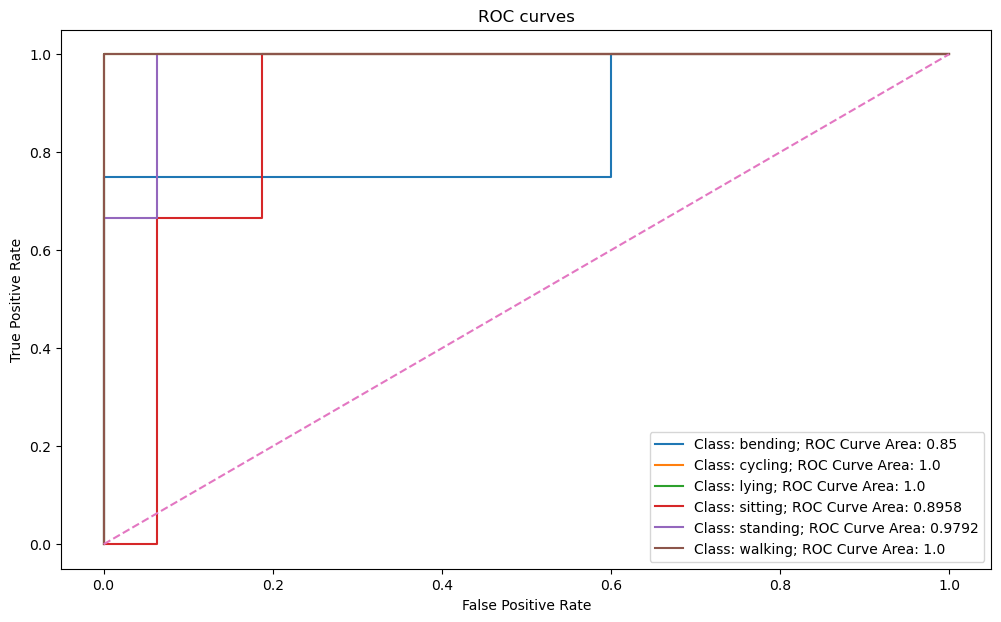

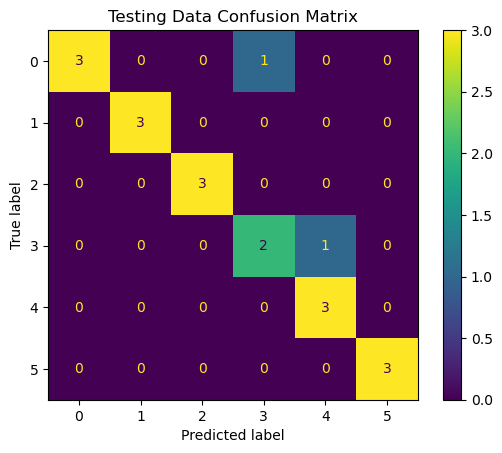

Testing Error :  0.10526315789473684


In [199]:


model = LogisticRegressionCV(penalty= 'l1', max_iter = 100, multi_class = 'multinomial',solver = 'saga', cv=5)
print('\nMultinomial Regression with Standardization')
print("\n-------------------------------------------------------\n")
res_df = get_best_l(model, 'lg')    
model_runner(model, 'lg', res_df)




Multinomial Regression without Standardization

-------------------------------------------------------



L     score
0    1  0.956522
1    2  0.985507
2    3  0.985507
3    4  1.000000
4    5  1.000000
5    6  0.985507
6    7  1.000000
7    8  1.000000
8    9  1.000000
9   10  1.000000
10  11  0.985507
11  12  1.000000
12  13  0.985507
13  14  1.000000
14  15  1.000000
15  16  1.000000
16  17  1.000000
17  18  1.000000
18  19  1.000000
19  20  1.000000

Best L value is : 4
Training Data ROC:


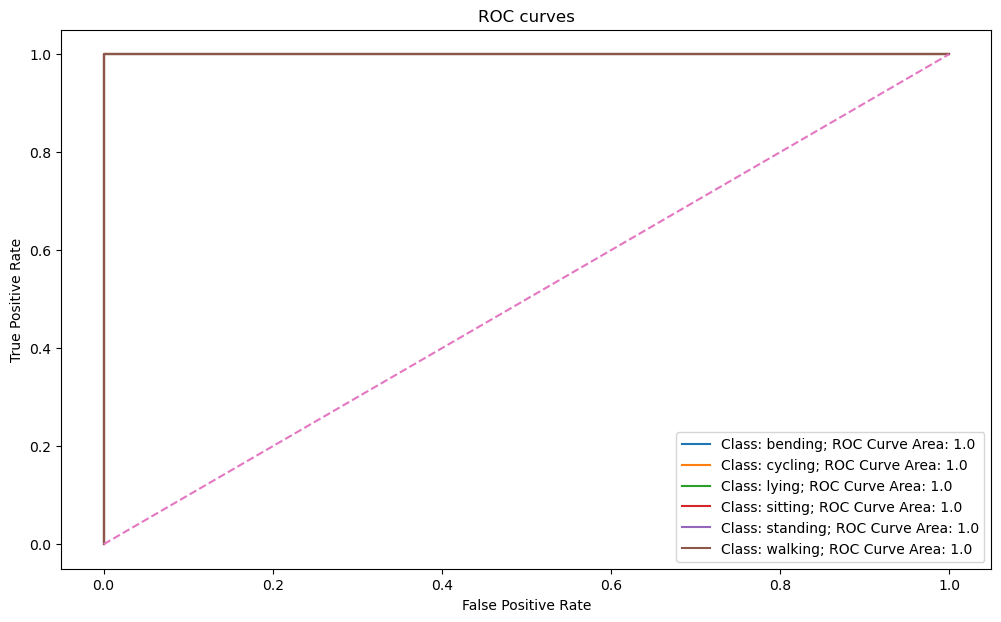

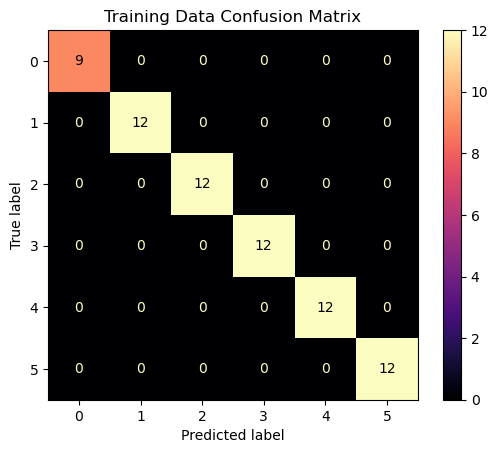

Tesingt Data ROC:


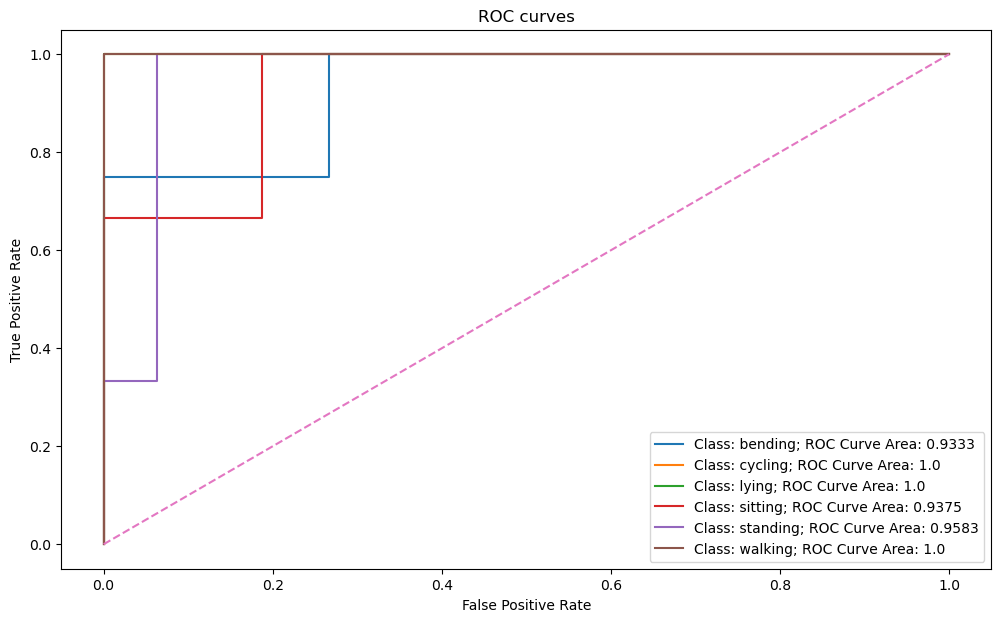

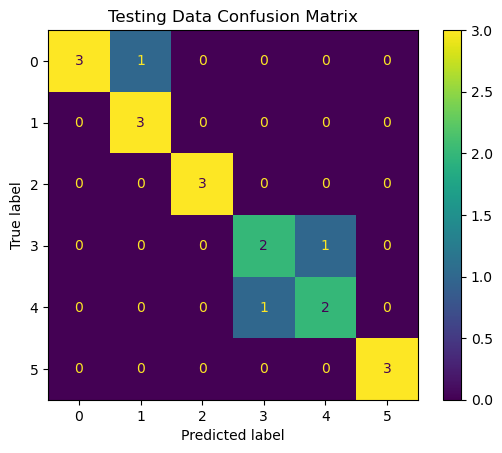

Testing Error :  0.1578947368421053


In [200]:
print('\nMultinomial Regression without Standardization')
print("\n-------------------------------------------------------\n")
res_df = get_best_l(model, 'lg-without standardization')

model_runner(model, 'lg-without standardization', res_df)

<h3>Q2. (c) ii. Repeat 2(c)i using a Na ̈ıve Bayes’ classifier. Use both Gaussian and Multinomial priors and compare the results.</h3>

<h4>Gaussian Classifier</h4>

In [201]:
model = GaussianNB()
res_df = get_best_l(model, 'gnb')  


L     score
0    1  0.956522
1    2  0.985507
2    3  0.971014
3    4  0.971014
4    5  0.971014
5    6  0.971014
6    7  0.985507
7    8  0.971014
8    9  0.985507
9   10  0.985507
10  11  0.985507
11  12  0.985507
12  13  0.985507
13  14  0.985507
14  15  0.985507
15  16  0.985507
16  17  0.985507
17  18  1.000000
18  19  0.985507
19  20  1.000000

Gaussian Classifier:

----------------------------------------------------

Best L value is : 18
Training Data ROC:


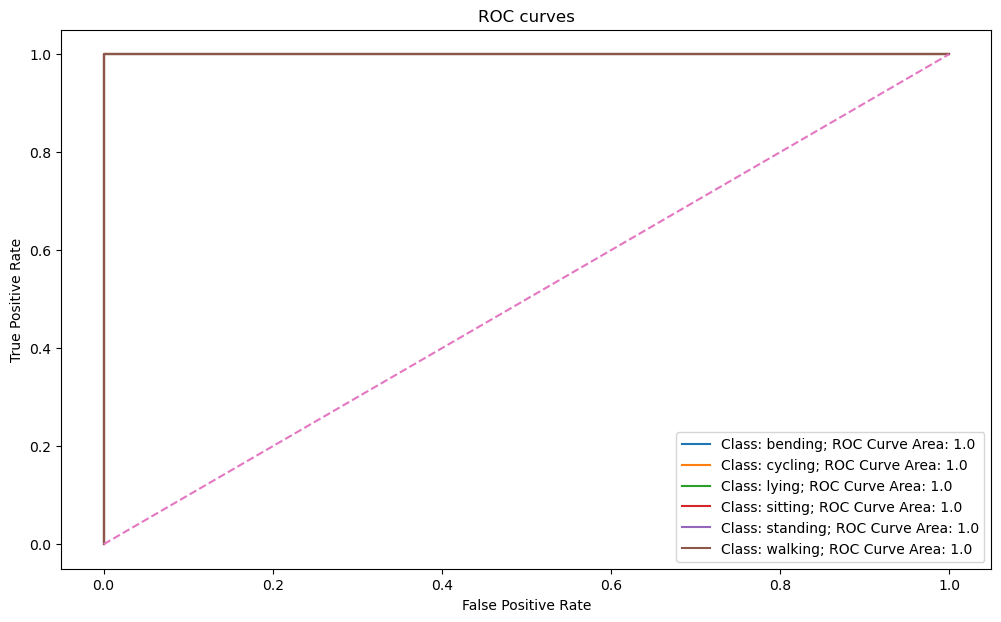

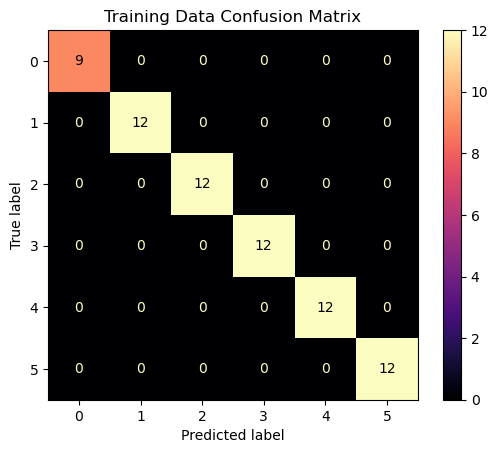

Tesingt Data ROC:


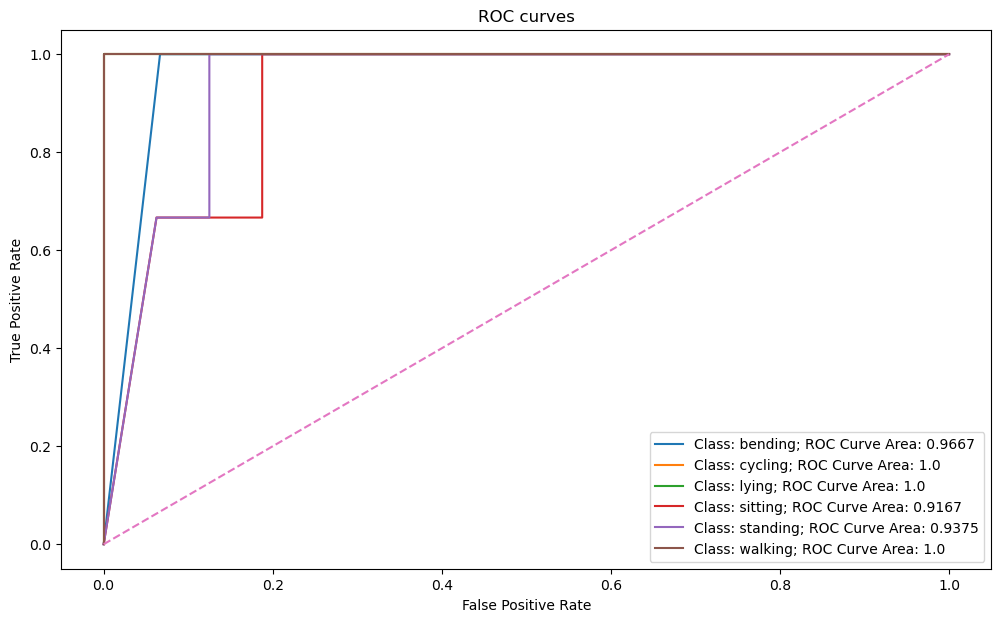

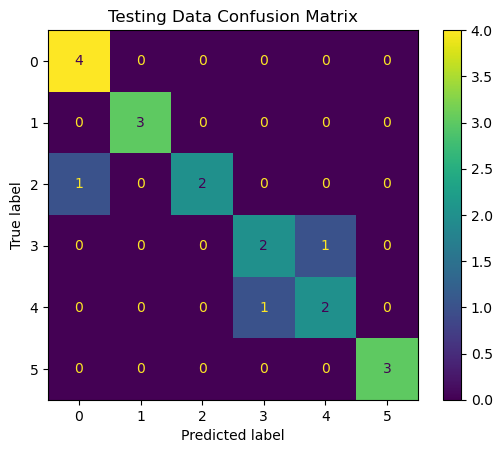

Testing Error :  0.1578947368421053


In [202]:
print("Gaussian Classifier:\n")
print("----------------------------------------------------\n")
model_runner(model,'gnb', res_df)

<h4>Multinomial Naive Bayes' Classifier</h4>

In [203]:
model = MultinomialNB()
res_df = get_best_l(model, 'mnb') 


L     score
0    1  0.898551
1    2  0.913043
2    3  0.942029
3    4  0.942029
4    5  0.956522
5    6  0.956522
6    7  0.956522
7    8  0.956522
8    9  0.956522
9   10  0.956522
10  11  0.956522
11  12  0.956522
12  13  0.956522
13  14  0.956522
14  15  0.956522
15  16  0.956522
16  17  0.956522
17  18  0.956522
18  19  0.956522
19  20  0.956522

GMultinomial Naive Bayes Classifier:

----------------------------------------------------

Best L value is : 5
Training Data ROC:


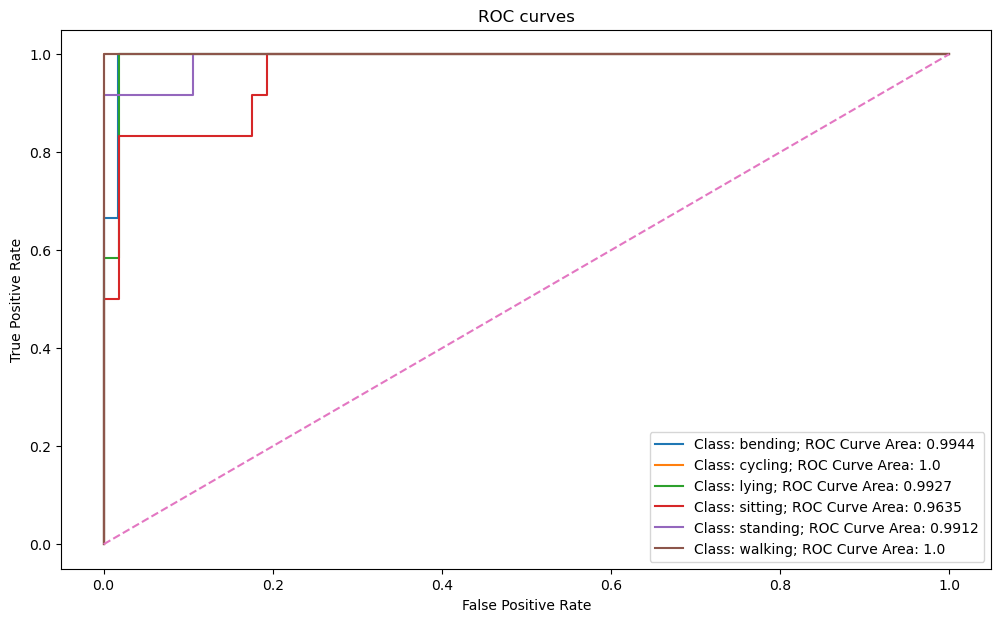

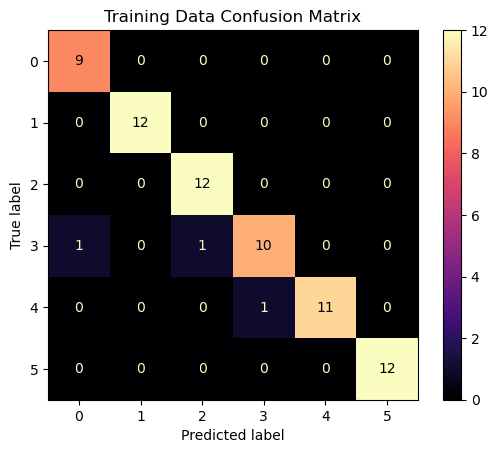

Tesingt Data ROC:


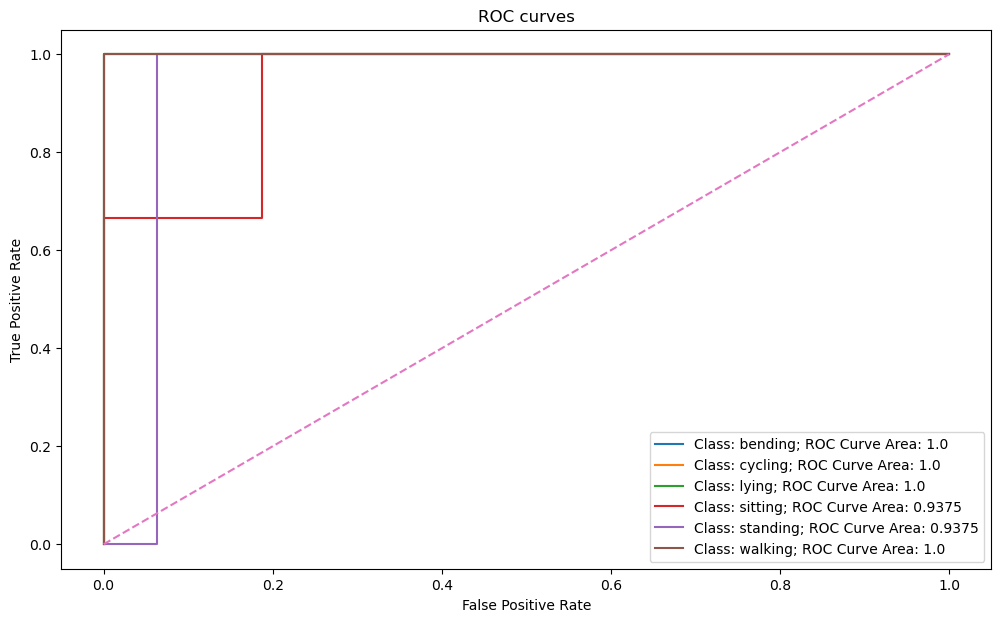

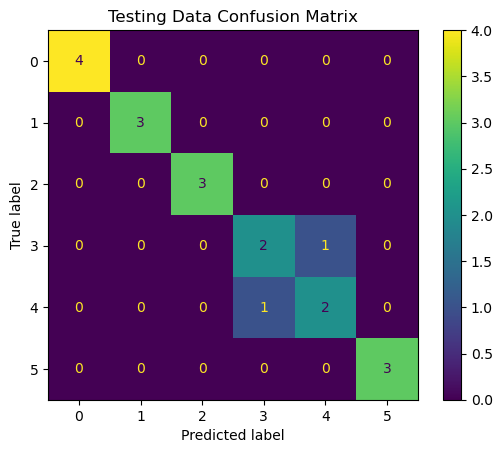

Testing Error :  0.10526315789473684


In [204]:
print("GMultinomial Naive Bayes Classifier:\n")
print("----------------------------------------------------\n")
model_runner(model, 'mnb', res_df)

<h3>Observation:</h3>
<h4>Between the multinomial and Gaussian Naive Bayes classifiers, the multinomial version shows better effectiveness, as indicated by its ROC curve analysis. This improved effectiveness suggests that the multinomial Naive Bayes is more capable of managing the dataset's features, potentially resulting in more dependable predictions across different scenarios.</h4>

<h3>Q2. (c) iii. Which method is better for multi-class classification in this problem?</h3>

<p> Based on the ROC curves analysis, the multinomial logistic regression classifier outperformed others on the dataset, with the multinomial Naive Bayes classifier coming in second, and the Gaussian Naive Bayes classifier ranking last. This ranking highlights the multinomial logistic regression's superior capability to accurately model and predict outcomes with this specific dataset, suggesting its potential as the preferred method for similar data challenges.</p>

<h3>Q3. ISLR 4.8.3 </h3>



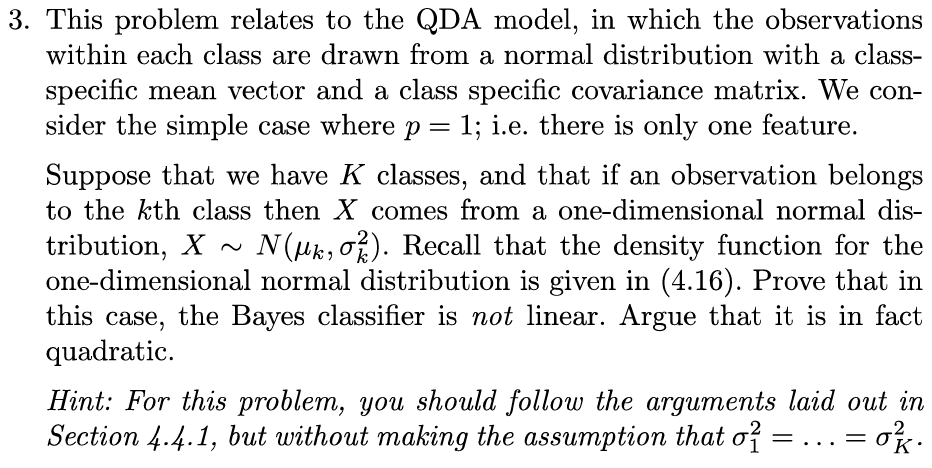

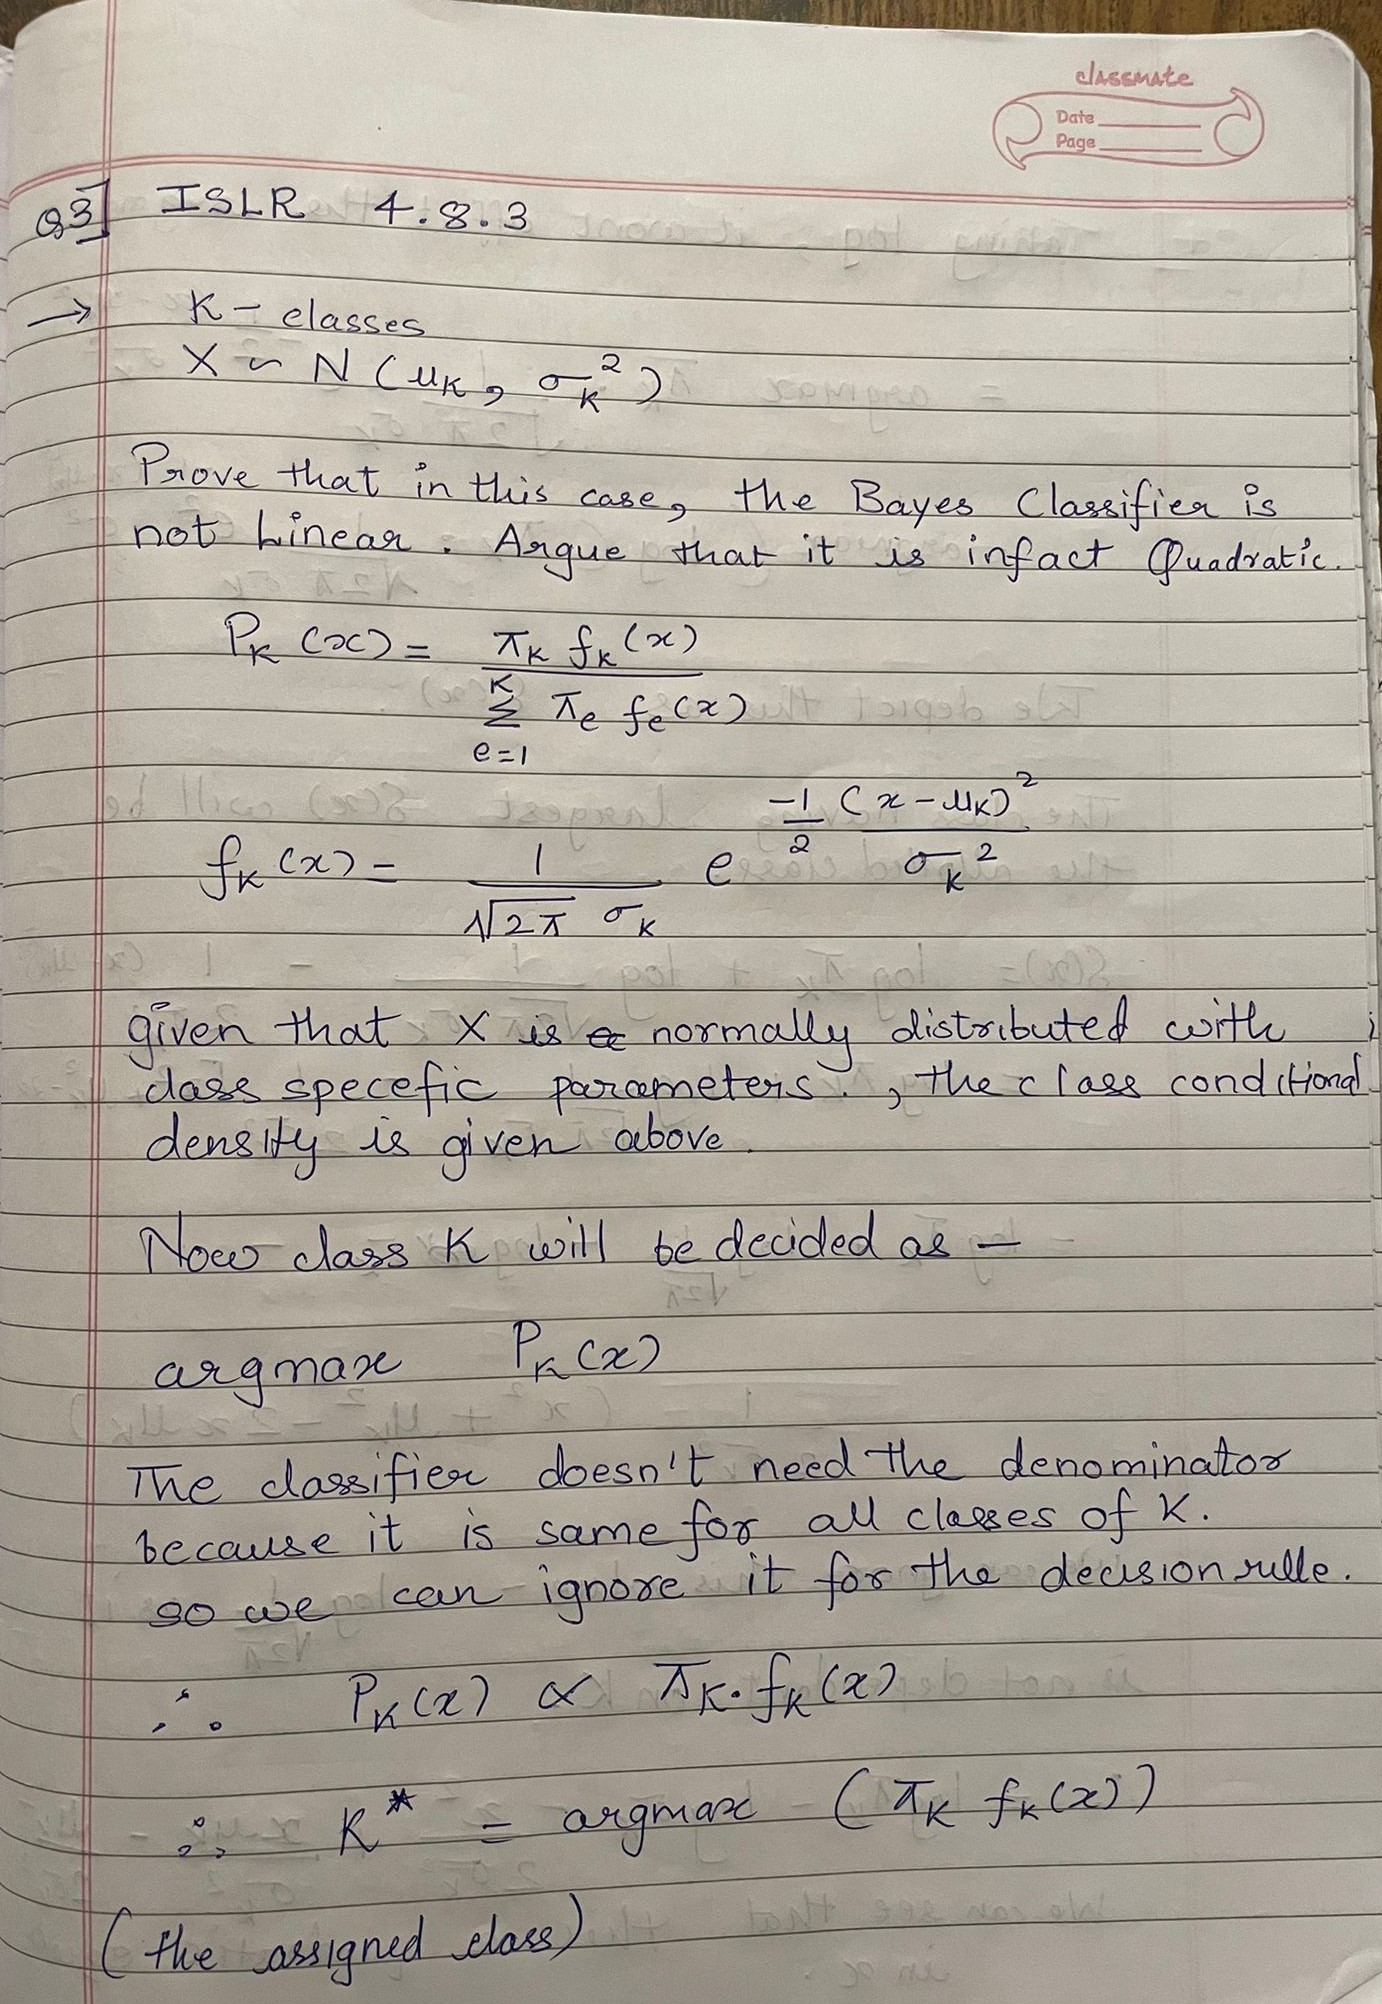


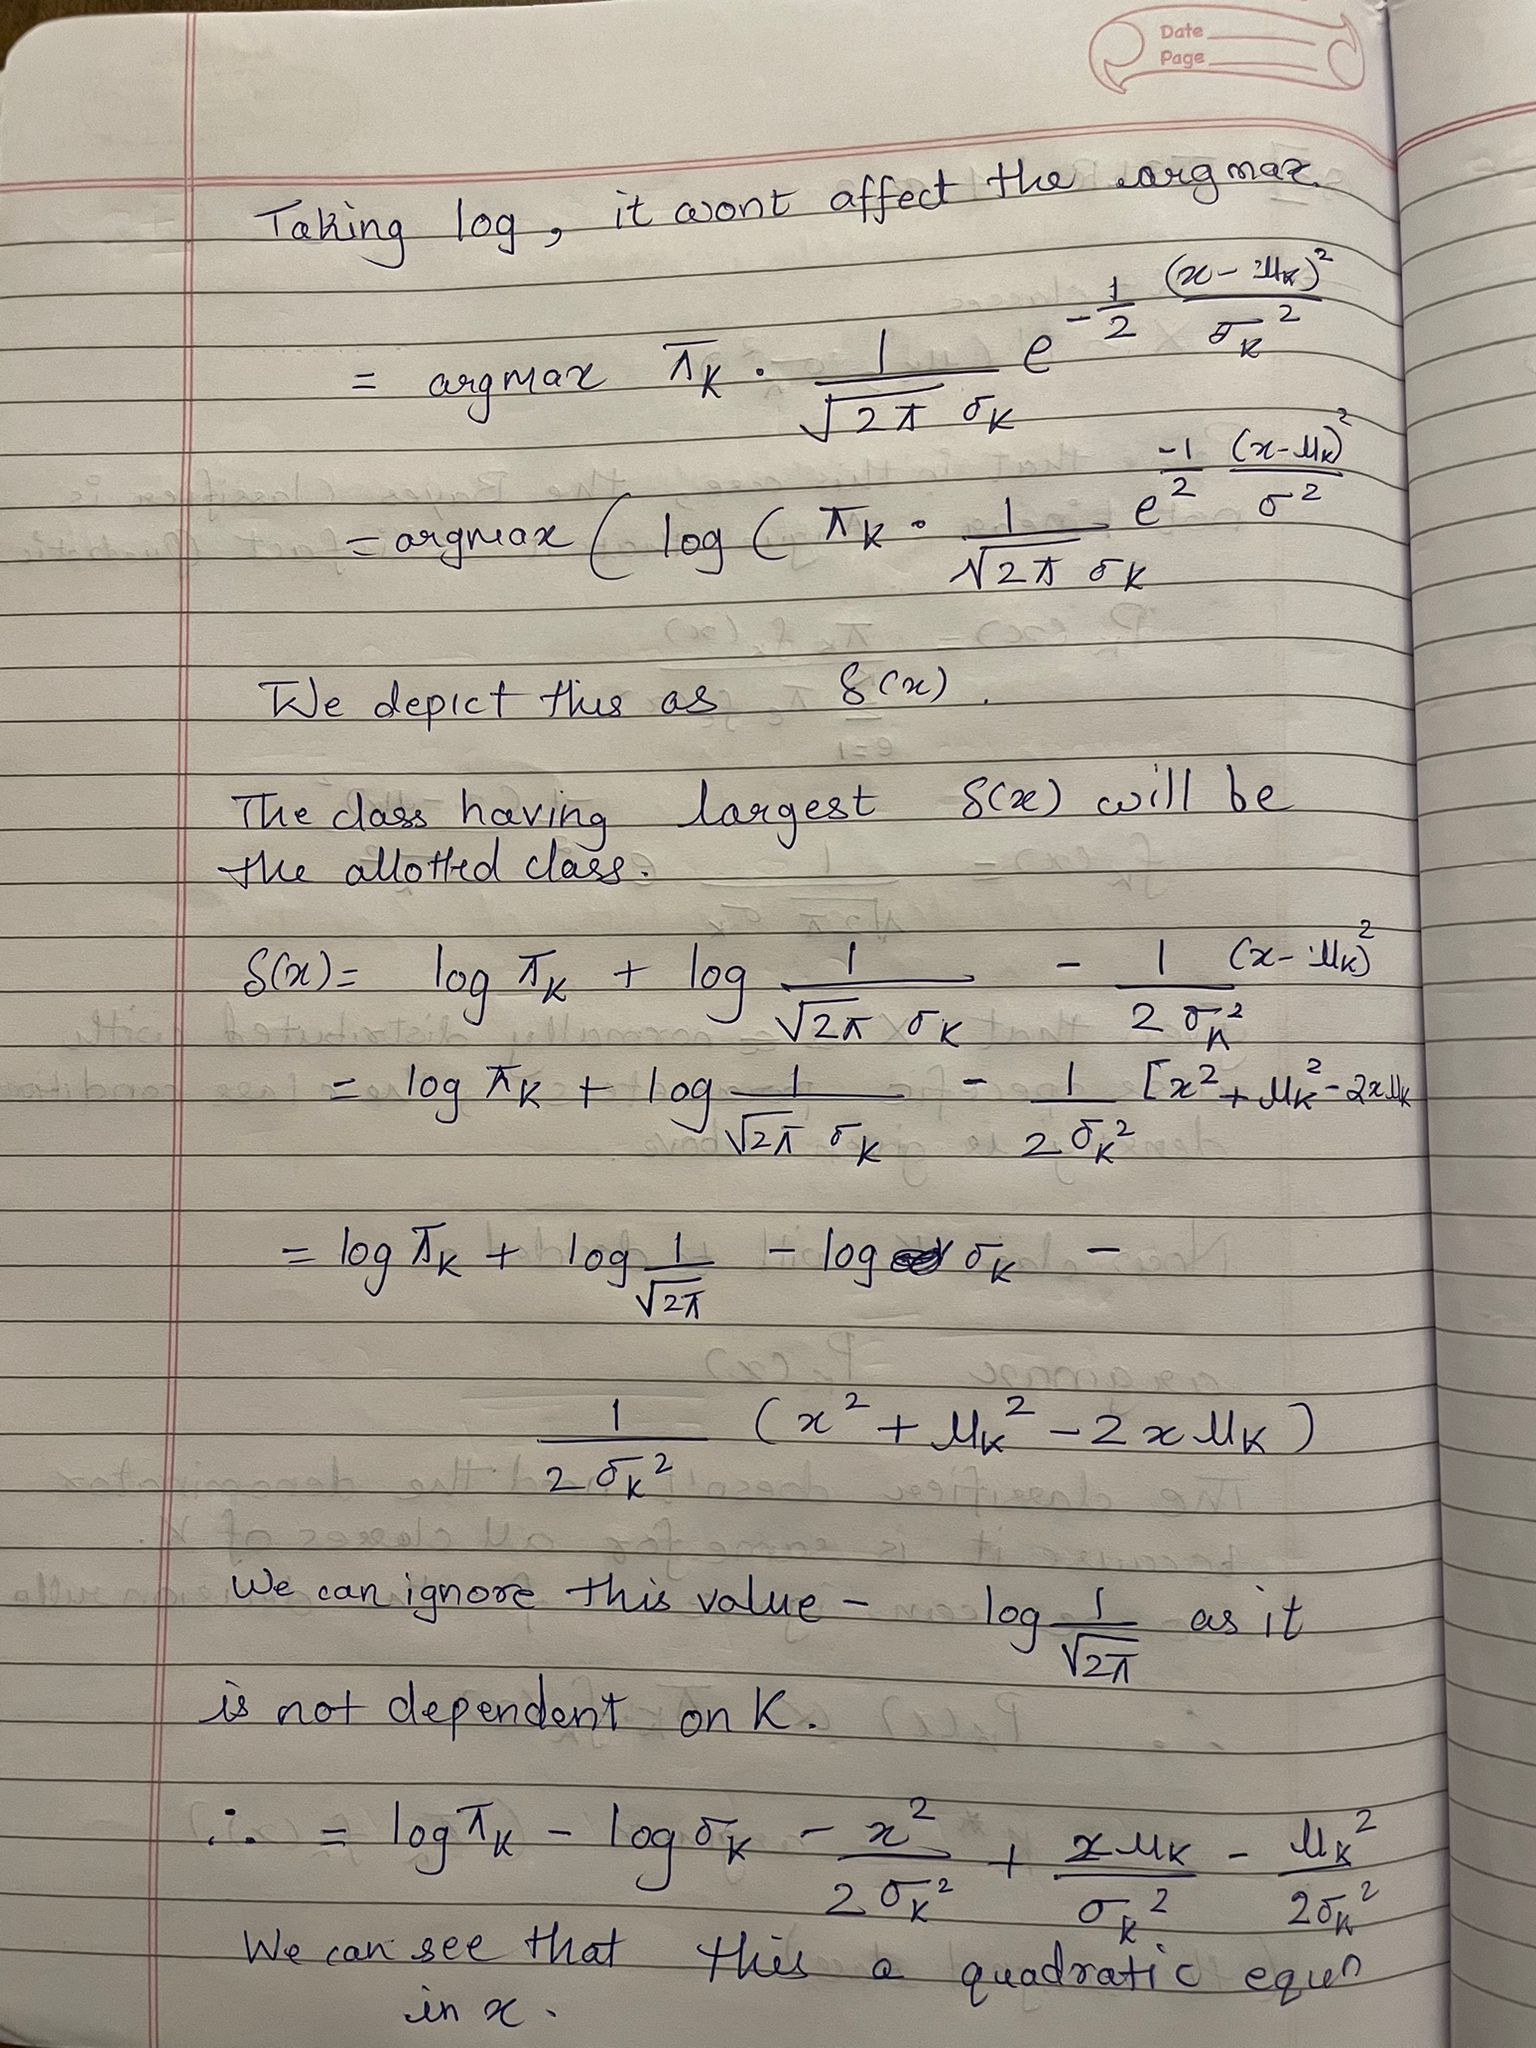

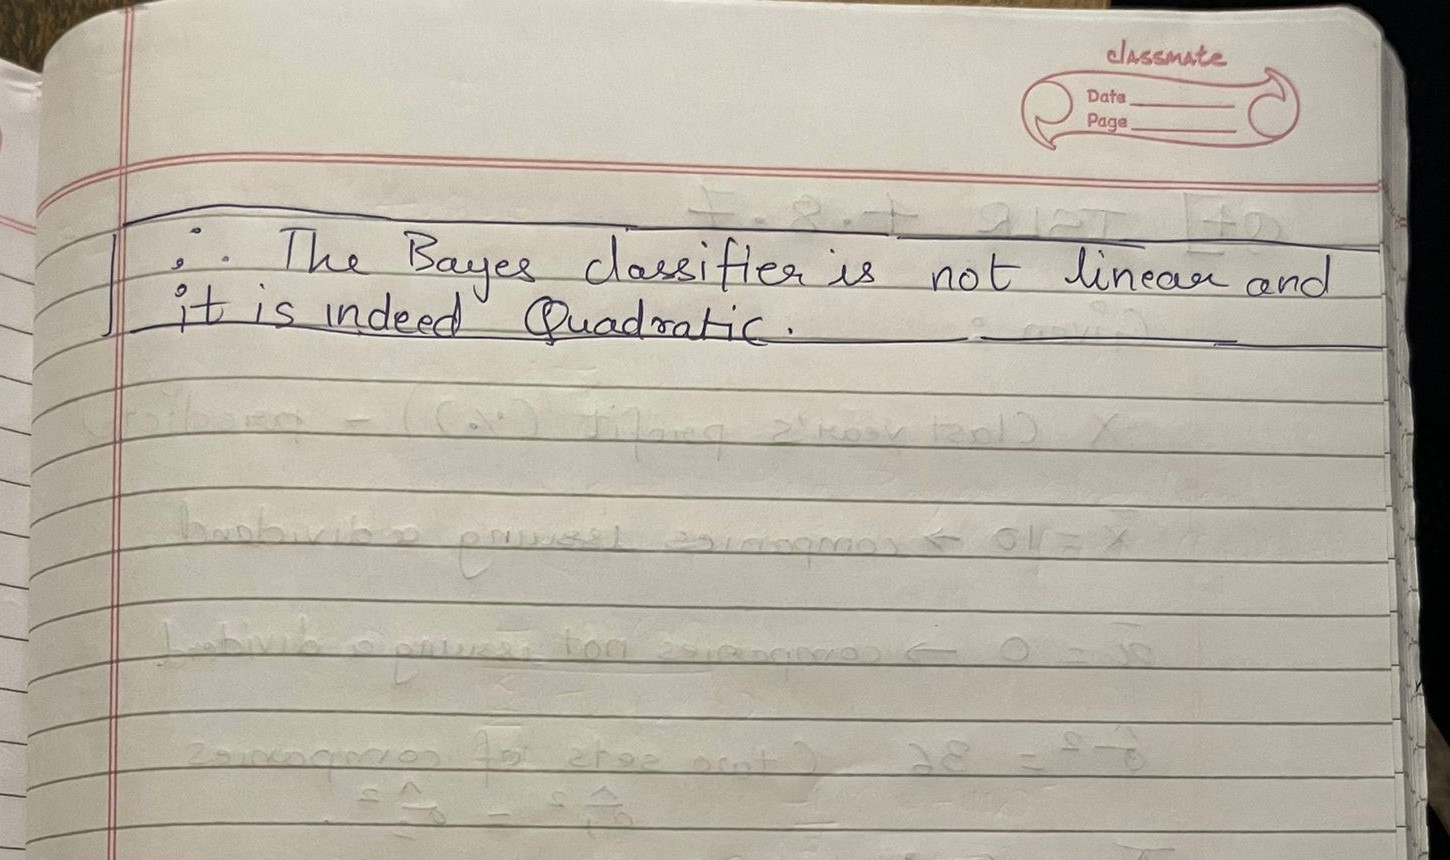

<h3>Q4. ISLR 4.8.7 </h3>



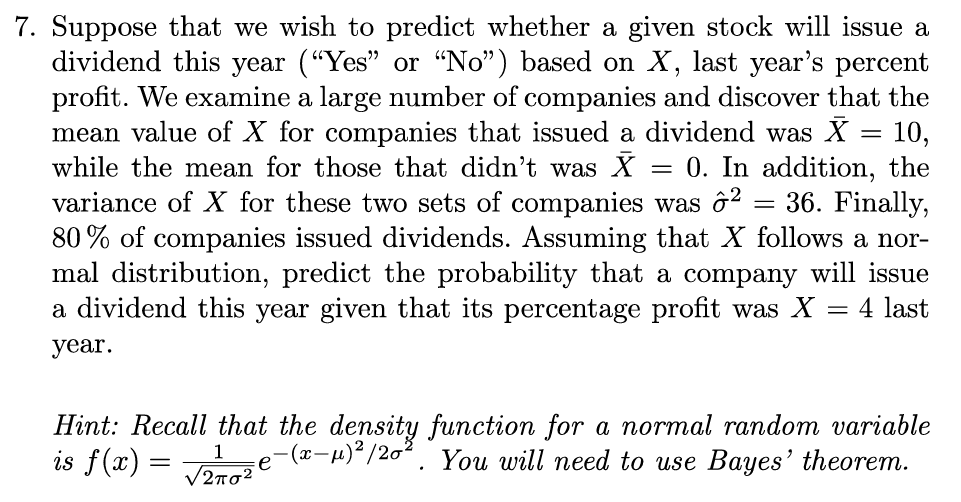

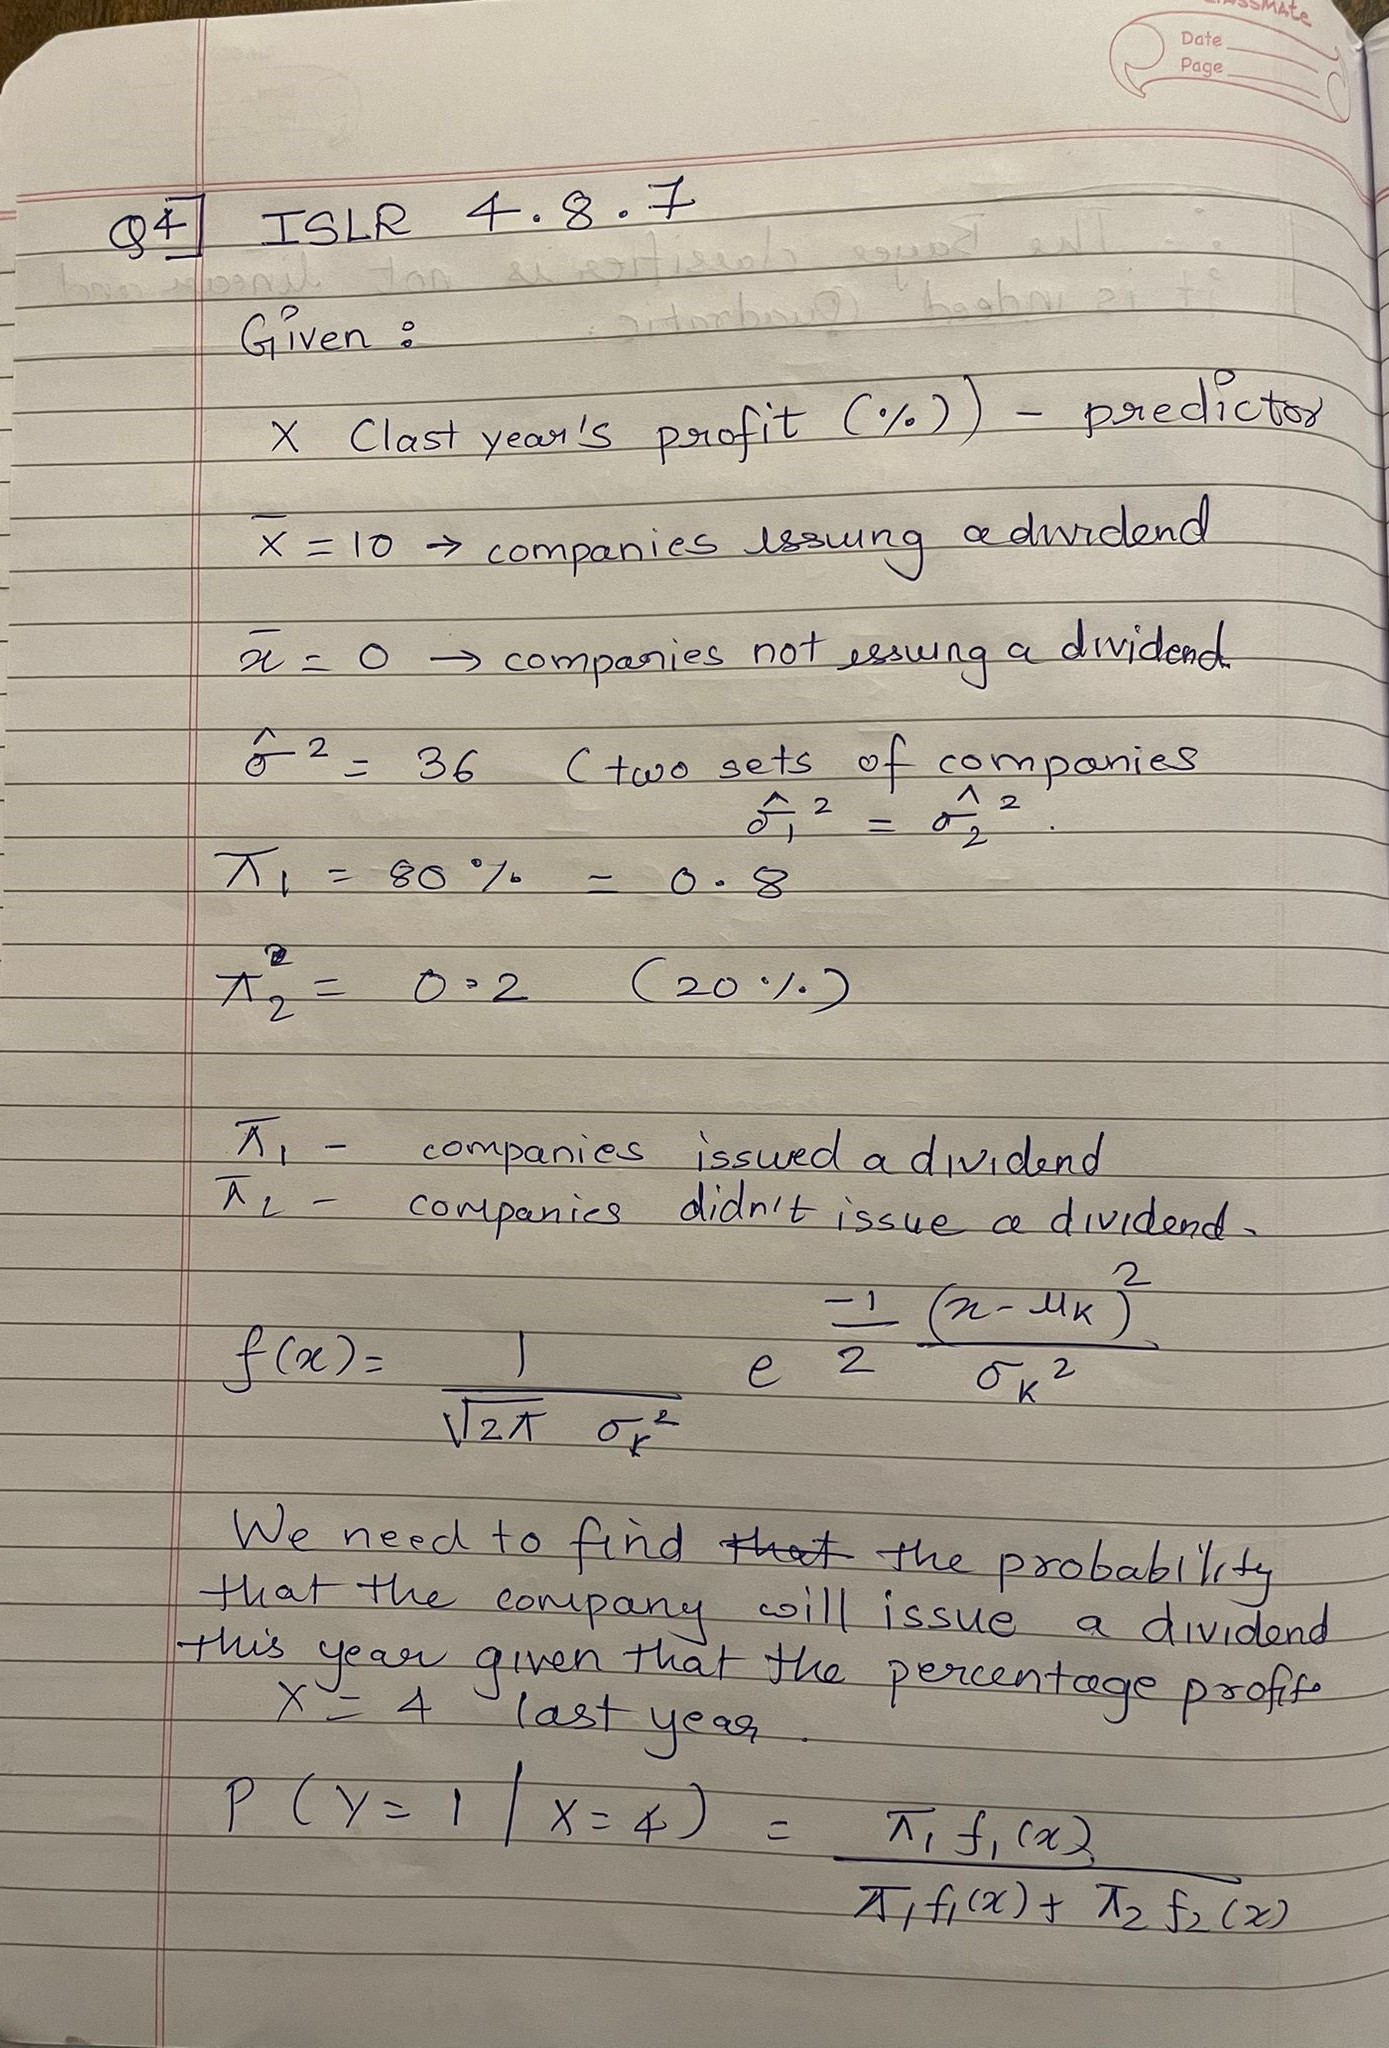

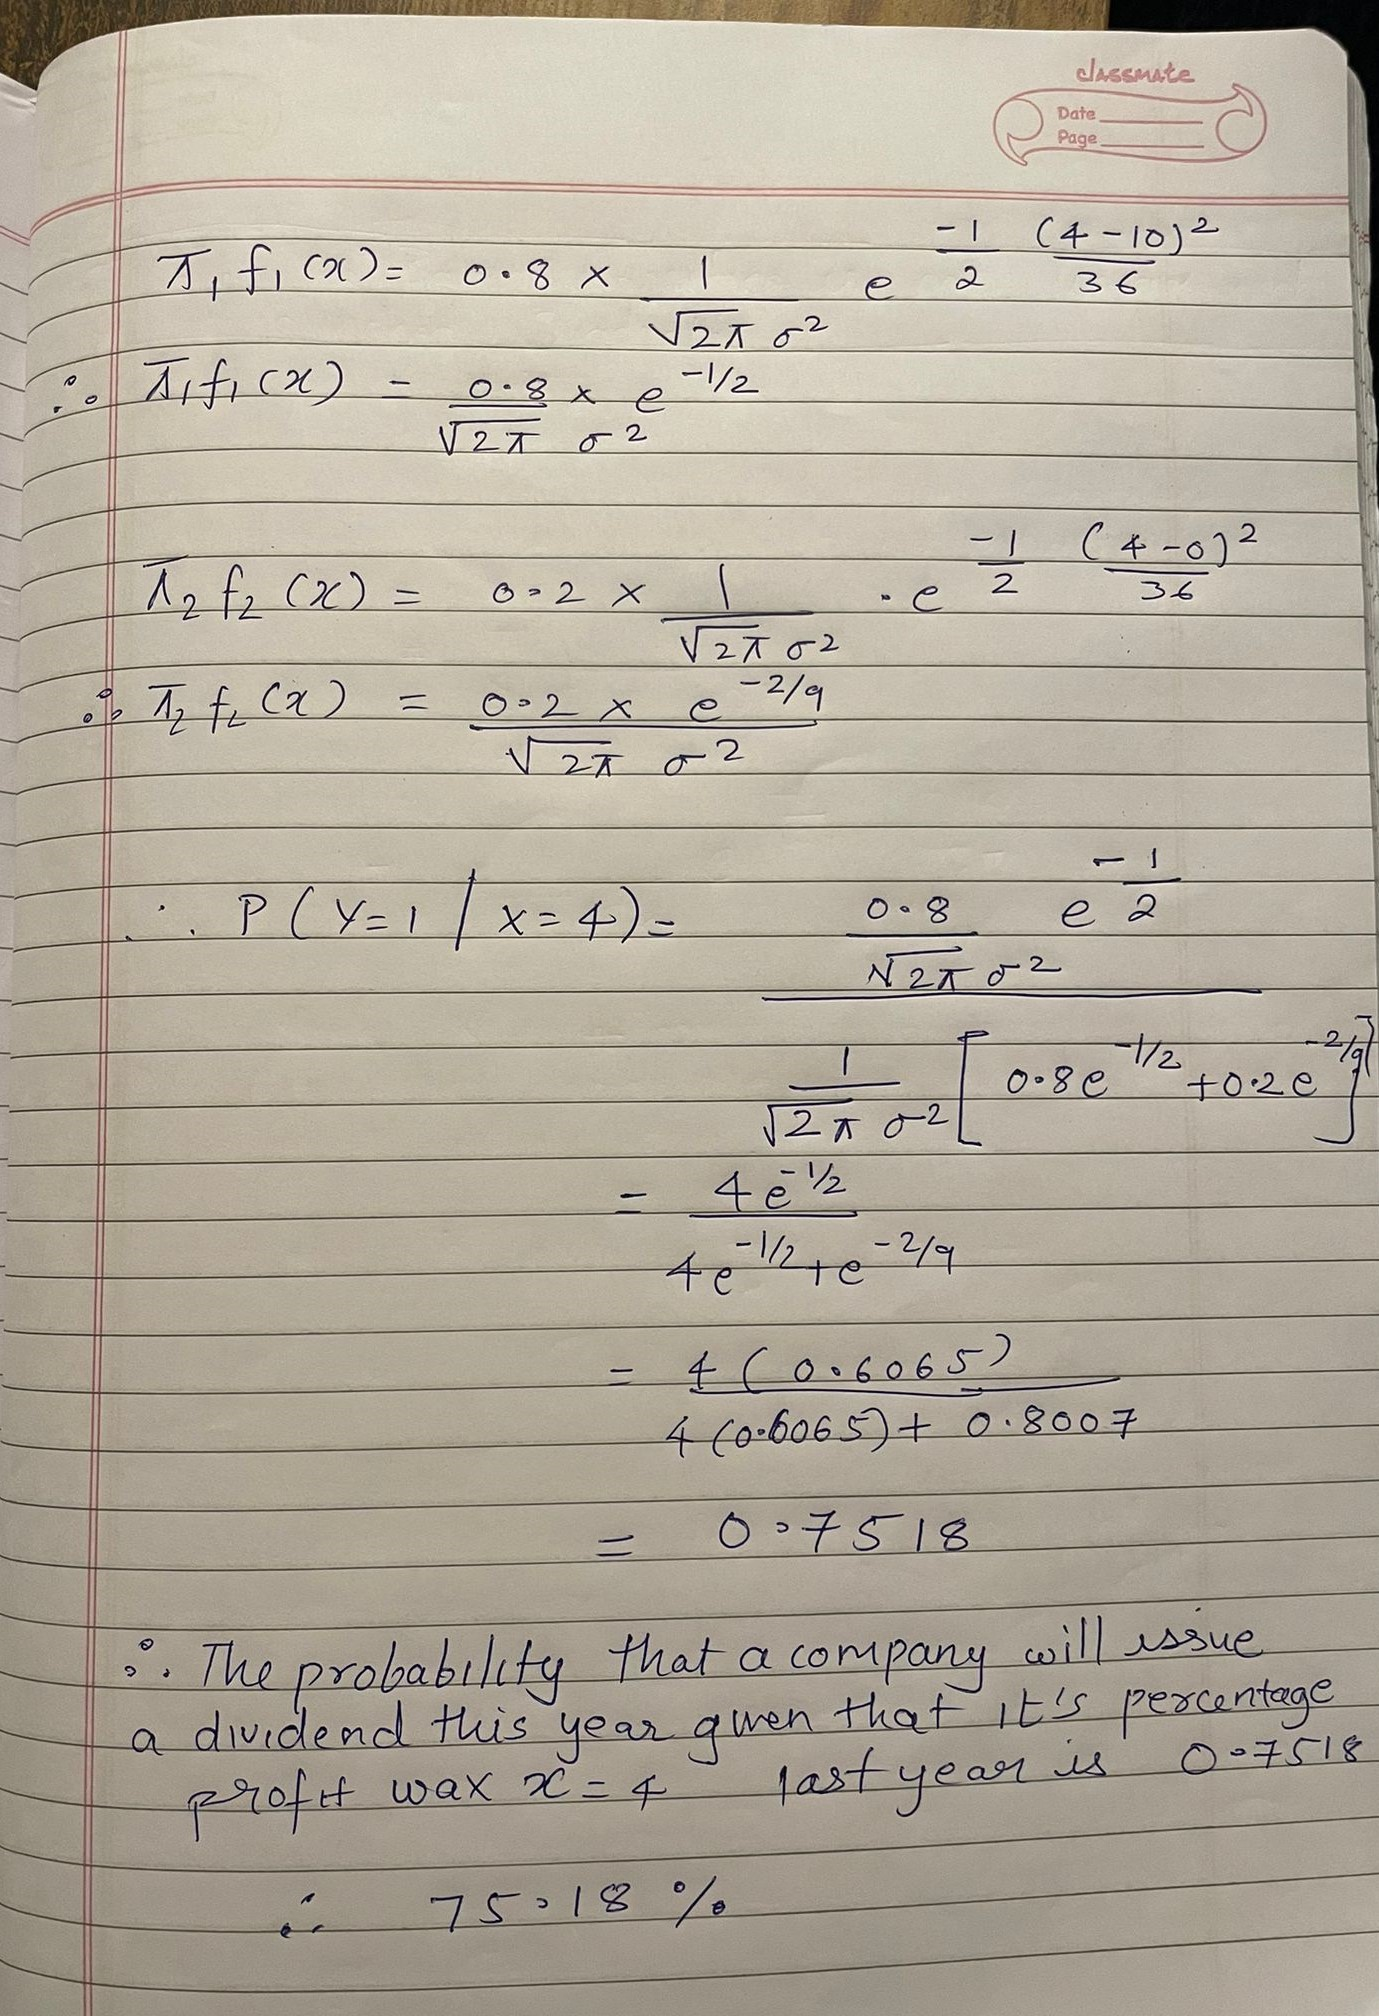

In [205]:
!pip freeze > requirements.txt



<h3>References:<h3/>
    

    
<hr>
<p><a>https://www.sciencedirect.com/topics/engineering/time-domain-processing#:~:text=Time%20domain%20features%20include%20the,and%20appear%20in%20each%20frame.&text=Amplitude%20envelope%20analysis%20(AE)%E2%80%94,all%20samples%20in%20a%20frame</a></p>
<p><a>https://stackoverflow.com/questions/64409272/classifying-pattern-in-time-series</a></p>
<p><a>https://machinelearningmastery.com/calculate-bootstrap-confidence-intervals-machine-learning-results-python/</a></p>
<p><a>https://saturncloud.io/blog/python-spyder-display-all-columns-of-a-pandas-dataframe-in-describe/#:~:text=describe()%E2%80%9D%20Method-,The%20.,and%20maximum%20of%20the%20columns.</a></p>
<p><a>https://stackoverflow.com/questions/58253445/standard-deviation-of-time-series</a></p>
<p><a>https://stackoverflow.com/questions/36423259/how-to-use-pretty-table-in-python-to-print-out-data-from-multiple-lists</a></p>
<p><a>https://towardsdatascience.com/basic-statistics-for-time-series-analysis-in-python-4cb147d56535</a></p>
